In [314]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import logging
import re
import pprint
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13

mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)

    exploded = exploded.drop(columns=columns)
    return exploded

def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)
    
df_erm = explode_erm_measures(df_erm)
df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  89


In [316]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "68"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(9)

experiment_id  \
21  387ab720-06c3-4d09-8876-9cf9fa591583   
20  41b7365f-3cfd-4102-8248-0be4a98e47ef   
23  448a2077-20ff-4ec3-bd2b-021a67aa8231   
22  4a2a158c-0c36-4c83-bd7f-061b405d6696   
24  cf4906c7-ce88-4592-bcad-7439fe9fce98   
17  59405e7a-826a-481a-a0ea-bbbcd3d6b923   
16  c513ed83-c03f-491f-9a2f-ddbbca5d7469   
19  2d6251c1-aee1-44bb-b120-c14a0d35f690   
18  ee229644-763f-4d71-a8a4-550d296bd2cc   

                                      experiment_name     duration  \
21  Sweep DataModel Protect Identity vs Attack Ide...  2793.694381   
20   Sweep DataModel Protect First vs Attack Identity  2684.339366   
23  Sweep DataModel Protect Identity vs Attack Second  2597.981718   
22   Sweep DataModel Protect Identity vs Attack First  2181.390039   
24  Sweep DataModel Protect Second vs Attack Identity  2030.494832   
17  Sweep Data-Model - Sweep DataModel Protect Fir...  3262.993370   
16  Sweep Data-Model - Sweep DataModel Protect Fir...  2448.348981   
19  Sweep Data-Model - Sweep DataModel Protect Sec...  2259.867049   
18  Sweep Data-Model - Sweep DataModel Protect Sec...  1995.889349   

   problem_types code_version                 date  \
21  ["Logistic"]           89  2023-12-01 12:01:36   
20  ["Logistic"]           89  2023-12-01 11:59:46   
23  ["Logistic"]           89  2023-12-01 11:58:26   
22  ["Logistic"]           89  2023-12-01 11:51:24   
24  ["Logistic"]           89  2023-12-01 11:49:06   
17  ["Logistic"]           89  2023-11-30 13:56:35   
16  ["Logistic"]           89  2023-11-30 13:41:58   
19  ["Logistic"]           89  2023-11-30 13:41:15   
18  ["Logistic"]           89  2023-11-30 13:36:51   

    state_evolution_repetitions  erm_repetitions      alphas         epsilons  \
21                            1                5  [158.4893]  [0.0, 0.2, 0.4]   
20                            1                5  [158.4893]  [0.0, 0.2, 0.4]   
23                            1                5  [158.4893]  [0.0, 0.2, 0.4]   
22                            1                5  [158.4893]  [0.0, 0.2, 0.4]   
24                            1                5  [158.4893]  [0.0, 0.2, 0.4]   
17                            1                5  [158.4893]  [0.0, 0.2, 0.4]   
16                            1                5  [158.4893]  [0.0, 0.2, 0.4]   
19                            1                5  [158.4893]  [0.0, 0.2, 0.4]   
18                            1                5  [158.4893]  [0.0, 0.2, 0.4]   

    ...    taus    ps    dp     d  experiment_type  completed  \
21  ...  [0, 1]  null  0.01  1000            Sweep          1   
20  ...  [0, 1]  null  0.01  1000            Sweep          1   
23  ...  [0, 1]  null  0.01  1000            Sweep          1   
22  ...  [0, 1]  null  0.01  1000            Sweep          1   
24  ...  [0, 1]  null  0.01  1000            Sweep          1   
17  ...  [0, 1]  null  0.01  1000            Sweep          1   
16  ...  [0, 1]  null  0.01  1000            Sweep          1   
19  ...  [0, 1]  null  0.01  1000            Sweep          1   
18  ...  [0, 1]  null  0.01  1000            Sweep          1   

                                     data_model_types  \
21  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
20  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
23  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
22  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
24  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
17  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
16  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
19  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
18  ["KFeaturesModel", "KFeaturesModel", "KFeature...   

                                     data_model_names  \
21  ["KFeaturesModel_TwoFeatures_ProtectingIdentit...   
20  ["KFeaturesModel_TwoFeatures_ProtectingFirstHa...   
23  ["KFeaturesModel_TwoFeatures_ProtectingIdentit...   
22  ["KFeaturesModel_TwoFeatures_ProtectingIdentit...   
24  ["KFeaturesModel_TwoFe

In [317]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [318]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)


# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
# for data_model_type in data_model_types:
#     print(data_model_type.name)
# print(data_model_names)
# print(data_model_descriptions)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

ee229644-763f-4d71-a8a4-550d296bd2cc
Sweep
Sweep Data-Model - Sweep DataModel Protect Second vs Attack Second
['Logistic']


In [319]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))
# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])


def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)

/tmp/ipykernel_3720724/60938954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/tmp/ipykernel_3720724/60938954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))
/tmp/ipykernel_3720724/60938954.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [320]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

duration_state_evolution  \
                                                                                                                              mean   
alpha    epsilon tau lam   problem_type attack_epsilon data_model_name                                                               
158.4893 0.0     0.0 0.001 Logistic     0.0            KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                      NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                      NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                      NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                      NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                      NaN   
...                                                                                                                            ...   
         0.4     1.0 0.001 Logistic     0.4            KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                 0.138462   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                 0.128706   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                 0.129848   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                 0.137635   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                 0.147461   

                                                                                                               \
                                                                                                          std   
alpha    epsilon tau lam   problem_type attack_epsilon data_model_name                                          
158.4893 0.0     0.0 0.001 Logistic     0.0            KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   
...                                                                                                        ..   
         0.4     1.0 0.001 Logistic     0.4            KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   
                                                       KFeaturesModel_TwoFeatures_ProtectingSecondHalf... NaN   

                                                                                                          generalization_error_state_evolution  \
                                                                                                                                          mean   
alpha    epsilon tau lam   problem_type attack_epsilon data_model_name                                                                           
158.4893 0.0     0.0 0.001 Logistic     0.0            KFeaturesModel_TwoFeatures_ProtectingSecondHalf...                                  NaN   
                                                       KFeatur

In [321]:
# # We need to test the FTerm, hence, let's load a bunch of data-models

# experiment = ExperimentInformation.from_df(df_experiments.iloc[experiment_loc])
# data_models = []
# for name, type in zip(data_model_names[:4], data_model_types[:4]):
#     print(name, type)
#     data_models.append(experiment._load_data_model(logger, name, type, source_pickle_path="./"))
# for model in data_models:
#     print(model.FTerm)
#     print(model.spec_FTerm)

# FTerms seem fine..

In [322]:
# first we need to extract some information from the data_model_name. 
# we can extract The Protected Half, the Attacked Half and the respective attack strengths. 

# a typical KFeature Name looks like this: KFeaturesModel_TwoFeatures_ProtectingSecondHalf_AttackingSecondHalf_[0.5 0.5]_[10 1]_[1 1]_SD_1_1.0_SU_1_1.0
# we need to extract the following information:
# - the protected half
# - the attacked half
# - the protection strength
# - the attack strength
# - the subspace strengths of the data

# KFeaturesModel_TwoFeatures_Protecting{Protected-Half}_Attacking{Attacked-Half}_[0.5 0.5]_[{Subspace-1 Strength} {Subspace-2 Strenght}]_[1 1]_SD_{Subspace-1 Protection Strength}_{Subspace-2 Protection Strength}_SU_{Subspace-1 Attack Strength}_{Subspace-2 Attack Strength}

# we can use the following regex to extract the information
regex = r"KFeaturesModel_TwoFeatures_Protecting(?P<protected_half>\w+)_Attacking(?P<attacked_half>\w+)_\[0.5 0.5\]_\[(?P<subspace_strengths>.+)\]_\[1 1\]_SD_(?P<subspace_protection_strengths>.+)_SU_(?P<subspace_attack_strengths>.+)"

# apply the regex to the data_model_name
df["data_model_name"] = df.index.get_level_values("data_model_name")
df["data_model_dict"] = df["data_model_name"].apply(lambda x: re.search(regex, x).groupdict())

# extract the subspace strengths
df["subspace_strengths"] = df["data_model_dict"].apply(lambda x: x["subspace_strengths"])
# convert the subspace strengths to a numpy array
df["subspace_strengths"] = df["subspace_strengths"].apply(lambda x: np.fromstring(x, dtype=float, sep=' '))
# extract the protection strengths
df["attack_strengths"] = df["data_model_dict"].apply(lambda x: x["subspace_attack_strengths"])
# convert the attack strengths to a numpy array
df["attack_strengths"] = df["attack_strengths"].apply(lambda x: np.fromstring(x, dtype=float, sep='_'))
# extract the protection strengths
df["protection_strengths"] = df["data_model_dict"].apply(lambda x: x["subspace_protection_strengths"])
# convert the protection strengths to a numpy array
df["protection_strengths"] = df["protection_strengths"].apply(lambda x: np.fromstring(x, dtype=float, sep='_'))
# extract the protected half
df["protected_half"] = df["data_model_dict"].apply(lambda x: x["protected_half"])
# make sure the datatype is str
df["protected_half"] = df["protected_half"].astype(str)
# extract the attacked half
df["attacked_half"] = df["data_model_dict"].apply(lambda x: x["attacked_half"])
# make sure the datatype is str
df["attacked_half"] = df["attacked_half"].astype(str)



# split the subspace strengths into two columns
df["subspace_strength_1"] = df["subspace_strengths"].apply(lambda x: x[0])
df["subspace_strength_2"] = df["subspace_strengths"].apply(lambda x: x[1])

# split the attack strengths into two columns
df["attack_strength_1"] = df["attack_strengths"].apply(lambda x: x[0])
df["attack_strength_2"] = df["attack_strengths"].apply(lambda x: x[1])

# split the protection strengths into two columns
df["protection_strength_1"] = df["protection_strengths"].apply(lambda x: x[0])
df["protection_strength_2"] = df["protection_strengths"].apply(lambda x: x[1])

def get_attack_strengths(row):
    # row["attacked_half"] is a pandas series, so we need to convert it to a string
    attacked_half = row["attacked_half"].to_string()
    # cut all leading or trailing whitespaces
    attacked_half = attacked_half.strip()
    if attacked_half == "FirstHalf":
        print("returing attack strength 1")
        return row["attack_strength_1"]
    else:
        return row["attack_strength_2"]
    
def get_protection_strengths(row):
    # row["protected_half"] is a pandas series, so we need to convert it to a string
    protected_half = row["protected_half"].to_string()
    # cut all leading or trailing whitespaces
    protected_half = protected_half.strip()
    if protected_half == "FirstHalf":
        return row["protection_strength_1"]
    else:
        return row["protection_strength_2"]

# create a column for the relevant attack strength
df["attack_strength"] = df.apply(get_attack_strengths, axis=1)

# create a column for the relevant protection strength
df["protection_strength"] = df.apply(get_protection_strengths, axis=1)

# drop the data_model_dict column
df = df.drop(columns=["data_model_dict"])

# drop the subspace_strengths column
df = df.drop(columns=["subspace_strengths"])

# drop the attack_strengths column
# df = df.drop(columns=["attack_strengths"])

# drop the protection_strengths column
df = df.drop(columns=["protection_strengths"])

# drop the data_model_name column
df = df.drop(columns=["data_model_name"])

# round all the columns to four digits
df = df.round(4)

# # fillna zero
# df = df.fillna(0)

# make sure df has a good index
df = df.reset_index()


/tmp/ipykernel_3720724/304212364.py:84: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns=["data_model_dict"])
/tmp/ipykernel_3720724/304212364.py:87: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns=["subspace_strengths"])
/tmp/ipykernel_3720724/304212364.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns=["protection_strengths"])
/tmp/ipykernel_3720724/304212364.py:96: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns=["data_model_name"])


In [323]:
df["attack_strengths"]

0          [1.0, 1.0]
1         [1.0, 10.0]
2        [1.0, 100.0]
3       [1.0, 3.1623]
4      [1.0, 31.6228]
            ...      
445        [1.0, 1.0]
446       [1.0, 10.0]
447      [1.0, 100.0]
448     [1.0, 3.1623]
449    [1.0, 31.6228]
Name: attack_strengths, Length: 450, dtype: object

In [324]:
df["attack_strengths"].apply(lambda x: x[0])

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
445    1.0
446    1.0
447    1.0
448    1.0
449    1.0
Name: attack_strengths, Length: 450, dtype: float64

In [325]:
df["attack_strength_1"]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
445    1.0
446    1.0
447    1.0
448    1.0
449    1.0
Name: attack_strength_1, Length: 450, dtype: float64

In [326]:
df[df["attacked_half"] == "FirstHalf"]

Empty DataFrame
Columns: [(alpha, ), (epsilon, ), (tau, ), (lam, ), (problem_type, ), (attack_epsilon, ), (data_model_name, ), (duration_state_evolution, mean), (duration_state_evolution, std), (generalization_error_state_evolution, mean), (generalization_error_state_evolution, std), (training_loss_state_evolution, mean), (training_loss_state_evolution, std), (training_error_state_evolution, mean), (training_error_state_evolution, std), (sigma_state_evolution, mean), (sigma_state_evolution, std), (q_state_evolution, mean), (q_state_evolution, std), (Q_self_state_evolution, mean), (Q_self_state_evolution, std), (m_state_evolution, mean), (m_state_evolution, std), (angle_state_evolution, mean), (angle_state_evolution, std), (rho_state_evolution, mean), (rho_state_evolution, std), (sigma_hat_state_evolution, mean), (sigma_hat_state_evolution, std), (q_hat_state_evolution, mean), (q_hat_state_evolution, std), (m_hat_state_evolution, mean), (m_hat_state_evolution, std), (A_state_evolution, mean), (A_state_evolution, std), (N_state_evolution, mean), (N_state_evolution, std), (P_state_evolution, mean), (P_state_evolution, std), (F_state_evolution, mean), (F_state_evolution, std), (A_hat_state_evolution, mean), (A_hat_state_evolution, std), (N_hat_state_evolution, mean), (N_hat_state_evolution, std), (adversarial_generalization_error_state_evolution, mean), (adversarial_generalization_error_state_evolution, std), (adversarial_generalization_error_teacher_state_evolution, mean), (adversarial_generalization_error_teacher_state_evolution, std), (fair_adversarial_error_state_evolution, mean), (fair_adversarial_error_state_evolution, std), (test_loss_state_evolution, mean), (test_loss_state_evolution, std), (estimation_error_state_evolution, mean), (estimation_error_state_evolution, std), (Sigma_0_state_evolution, mean), (Sigma_0_state_evolution, std), (Sigma_1_state_evolution, mean), (Sigma_1_state_evolution, std), (m_0_state_evolution, mean), (m_0_state_evolution, std), (m_1_state_evolution, mean), (m_1_state_evolution, std), (q_0_state_evolution, mean), (q_0_state_evolution, std), (q_1_state_evolution, mean), (q_1_state_evolution, std), (A_0_state_evolution, mean), (A_0_state_evolution, std), (A_1_state_evolution, mean), (A_1_state_evolution, std), (N_0_state_evolution, mean), (N_0_state_evolution, std), (N_1_state_evolution, mean), (N_1_state_evolution, std), (P_0_state_evolution, mean), (P_0_state_evolution, std), (P_1_state_evolution, mean), (P_1_state_evolution, std), (F_0_state_evolution, mean), (F_0_state_evolution, std), (F_1_state_evolution, mean), (F_1_state_evolution, std), (duration_erm, mean), (duration_erm, std), (q_erm, mean), (q_erm, std), (rho_erm, mean), (rho_erm, std), (m_erm, mean), (m_erm, std), (angle_erm, mean), (angle_erm, std), (generalization_error_erm_erm, mean), (generalization_error_erm_erm, std), (generalization_error_overlap_erm, mean), (generalization_error_overlap_erm, std), (training_error_erm, mean), (training_error_erm, std), (training_loss_erm, mean), ...]
Index: []

[0 rows x 160 columns]

In [327]:
df["attack_strength"]

0        1.0000
1       10.0000
2      100.0000
3        3.1623
4       31.6228
         ...   
445      1.0000
446     10.0000
447    100.0000
448      3.1623
449     31.6228
Name: attack_strength, Length: 450, dtype: float64

In [328]:
# get unique attacked_half, protected_half
attacked_half = df["attacked_half"].unique()
protected_half = df["protected_half"].unique()
print(attacked_half, protected_half)

['SecondHalf'] ['SecondHalf']


In [329]:
# get unique protection strength and attack strength
protection_strength = df["protection_strength"].unique()
attack_strength = df["attack_strength"].unique()
print(attack_strength, protection_strength)

[  1.      10.     100.       3.1623  31.6228] [  1.      10.     100.       3.1623  31.6228]


In [330]:
# Let's compute the subspace overlap ratios.
# The subspace overlap ratio is the ratio of the subspace overlap to the subspace strength.

# Now the question is, which overlaps do we want to compute and by which strengths do we want to divide?
# F: divide by the attack strength
# m: divide by the data strength


# the subspace overlap names are given by {overlap}_{i}_state_evolution or {overlap}_{i}_erm

df["F_0_state_evolution_normalized"] = df["F_0_state_evolution"]["mean"] / df["attack_strength_1"]
df["F_1_state_evolution_normalized"] = df["F_1_state_evolution"]["mean"] / df["attack_strength_2"]
df["F_subspace_ratio_state_evolution"] = df["F_0_state_evolution_normalized"] / df["F_1_state_evolution_normalized"]


df["F_0_erm_normalized"] = df["F_0_erm"]["mean"] / df["attack_strength_1"]
df["F_1_erm_normalized"] = df["F_1_erm"]["mean"] / df["attack_strength_2"]
df["F_subspace_ratio_erm"] = df["F_0_erm_normalized"] / df["F_1_erm_normalized"]

df["m_0_state_evolution_normalized"] = df["m_0_state_evolution"]["mean"] / df["subspace_strength_1"]
df["m_1_state_evolution_normalized"] = df["m_1_state_evolution"]["mean"] / df["subspace_strength_2"]
df["m_subspace_ratio_state_evolution"] = df["m_0_state_evolution_normalized"] / df["m_1_state_evolution_normalized"]

df["m_0_erm_normalized"] = df["m_0_erm"]["mean"] / df["subspace_strength_1"]
df["m_1_erm_normalized"] = df["m_1_erm"]["mean"] / df["subspace_strength_2"]
df["m_subspace_ratio_erm"] = df["m_0_erm_normalized"] / df["m_1_erm_normalized"]

df["q_0_state_evolution_normalized"] = df["q_0_state_evolution"]["mean"] / df["subspace_strength_1"]
df["q_1_state_evolution_normalized"] = df["q_1_state_evolution"]["mean"] / df["subspace_strength_2"]
df["q_subspace_ratio_state_evolution"] = df["q_0_state_evolution_normalized"] / df["q_1_state_evolution_normalized"]

df["q_0_erm_normalized"] = df["q_0_erm"]["mean"] / df["subspace_strength_1"]
df["q_1_erm_normalized"] = df["q_1_erm"]["mean"] / df["subspace_strength_2"]
df["q_subspace_ratio_erm"] = df["q_0_erm_normalized"] / df["q_1_erm_normalized"]


# # fillna zero
# df = df.fillna(0)

In [331]:

save_plots = True
description = ""




def create_plot(df, display_name, dataframe_name, iterate_attack_strengths = False, use_mean = False):
    # copy the dataframe
    df2 = df.copy()
    # remove the index
    df2 = df2.reset_index()


    # preparation

    state_evolution_name = dataframe_name + "_state_evolution"
    erm_name = dataframe_name + "_erm"

    if use_mean == True:
        state_evolution_name = state_evolution_name + " mean"
        erm_name = erm_name + " mean"

    for alpha in df2["alpha"].unique():

        for tau in df2["tau"].unique():

            for epsilon in df2["epsilon"].unique():

                for lam in df2["lam"].unique():

                    for problem_type in df2["problem_type"].unique():

                        attack_epsilons = df2["attack_epsilon"].unique()
                        if not iterate_attack_strengths:
                            attack_epsilons = [None]

                        for attack_epsilon in attack_epsilons:
                                               
                            if iterate_attack_strengths:
                                data = df2[(df2["tau"] == tau) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon) & (df2["alpha"] == alpha) & (df2["epsilon"] == epsilon) & (df2["lam"] == lam)]
                            else:
                                data = df2[(df2["tau"] == tau) & (df2["problem_type"] == problem_type) & (df2["alpha"] == alpha) & (df2["epsilon"] == epsilon) & (df2["lam"] == lam)]

                            print("alpha: ", alpha, " tau: ", tau, " epsilon: ", epsilon, " lam: ", lam, " attack_epsilon: ", attack_epsilon, " problem_type: ", problem_type)

                            # data = data.fillna(-1)


                            data.columns = [' '.join(col).strip() for col in data.columns.values]

                            


                            # Pivot the DataFrame for better visualization
                            pivot_state_evolution_df = data.pivot_table(index='attack_strength', columns=['protection_strength'], values=state_evolution_name, dropna=False)

                            pivot_erm_df = data.pivot_table(index='attack_strength', columns=['protection_strength'], values=erm_name, dropna=False)


                            # extract the protection stengths from the pivot_df and convert them to a numpy array
                            protection_strengths = pivot_state_evolution_df.columns.values 
                            # reverse the attack strength order in pivot_df
                            pivot_state_evolution_df = pivot_state_evolution_df.iloc[::-1]
                            # reverse the order also for erm
                            pivot_erm_df = pivot_erm_df.iloc[::-1]

                            # Let's create an annotation table for the heatmap containing the state evolution values / erm values
                            # Create a copy of the pivot table
                            # Extract a numpy array with values for the heatmap
                            # Replace all nan values with NaN strings
                            
                            # pivot_state_evolution_df to numpy array
                            pivot_state_evolution_df_np = pivot_state_evolution_df.to_numpy()
                            # replace nan values with NaN strings
                            pivot_state_evolution_df_np[pd.isnull(pivot_state_evolution_df_np)] = "NaN"
                            # round the values to 2 digits
                            pivot_state_evolution_df_np = np.round(pivot_state_evolution_df_np, 2)
                            # change dtype to string
                            pivot_state_evolution_df_np = pivot_state_evolution_df_np.astype(str)
                            # pivot_erm_df to numpy array
                            pivot_erm_df_np = pivot_erm_df.to_numpy()
                            # replace nan values with NaN strings
                            pivot_erm_df_np[pd.isnull(pivot_erm_df_np)] = "NaN"
                            # round the values to 2 digits
                            pivot_erm_df_np = np.round(pivot_erm_df_np, 2)
                            # change dtype to string
                            pivot_erm_df_np = pivot_erm_df_np.astype(str)

                            # combine the two numpy arrays elementwise and insert "/" between the values
                            pivot_df_np = np.core.defchararray.add(pivot_state_evolution_df_np, " / ")
                            pivot_df_np = np.core.defchararray.add(pivot_df_np, pivot_erm_df_np)
                            

                            # set the title of the pivot table
                            pivot_state_evolution_df.columns.name = display_name

                            # Create a heatmap with mean values and standard deviation
                            # plt.figure(figsize=(12, 6))
                            fig, ax = plt.subplots(squeeze=False, figsize=(12, 6))

                            

                            
                            sns.heatmap(
                                np.where(pivot_state_evolution_df.isna(), 0, np.nan),
                                ax=ax[0, 0],
                                cbar=False,
                                annot=pivot_df_np,
                                fmt="",
                                annot_kws={"size": 10, "va": "center_baseline", "color": "black"},
                                cmap=ListedColormap(['none']),
                                linewidth=0)

                            # fmt=".2f"
                            sns.heatmap(pivot_state_evolution_df, ax=ax[0, 0], fmt = '', annot=pivot_df_np, cmap="YlGnBu", linewidths=.5, cbar_kws={'label': display_name}, xticklabels = protection_strengths)    

                            if iterate_attack_strengths:
                                title = f"{display_name}: alpha={alpha}, tau={tau}, epsilon={epsilon}\n lam={lam}, attack_epsilon={attack_epsilon}, problem_type={problem_type} \n {experiment_name}"
                            else:
                                title = f"{display_name}: alpha={alpha}, tau={tau}, epsilon={epsilon}\n lam={lam}, problem_type={problem_type} \n {experiment_name}"

                            plt.title(title)

                            # set y label to Attack Strength and x label to Protection Strength
                            plt.ylabel("Attack Strength")
                            plt.xlabel("Protection Strength")

                            name = f"{display_name}_{problem_type}_tau_{tau}_lam_{lam}_v_{__version__}"
                            if iterate_attack_strengths:
                                name += f"_attack_epsilon_{attack_epsilon}"
                            # Save the plot as svg
                            if save_plots:
                                
                                # create the path for experiment_name
                                path = f"Assets/ColorMaps/{experiment_name}/"

                                if description != "":
                                    path += f"{description}/"

                                # create the directory if it does not exist
                                os.makedirs(path, exist_ok=True)

                                plt.savefig(f"{path}{name}.pdf", bbox_inches='tight')

                            plt.show()


alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


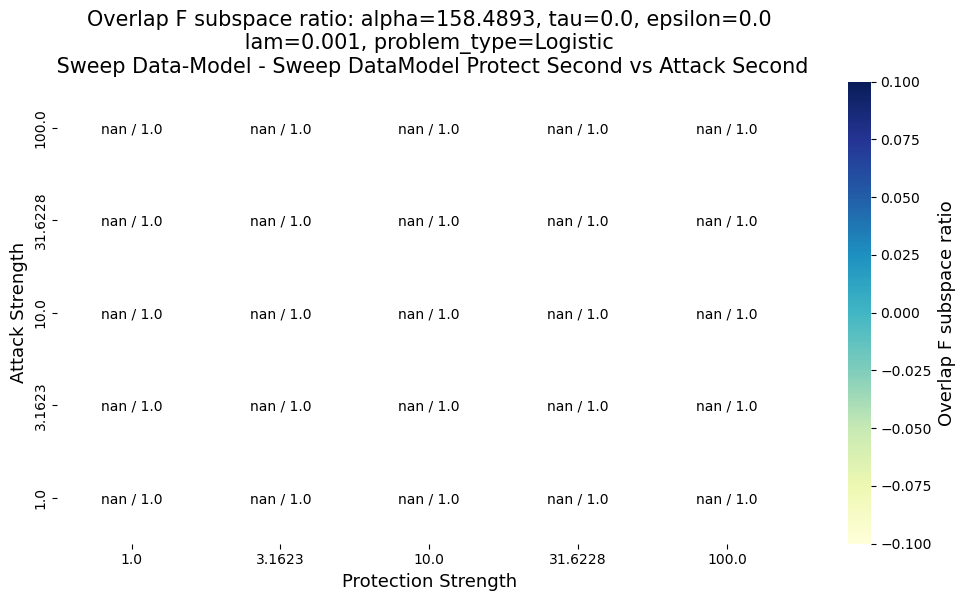

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


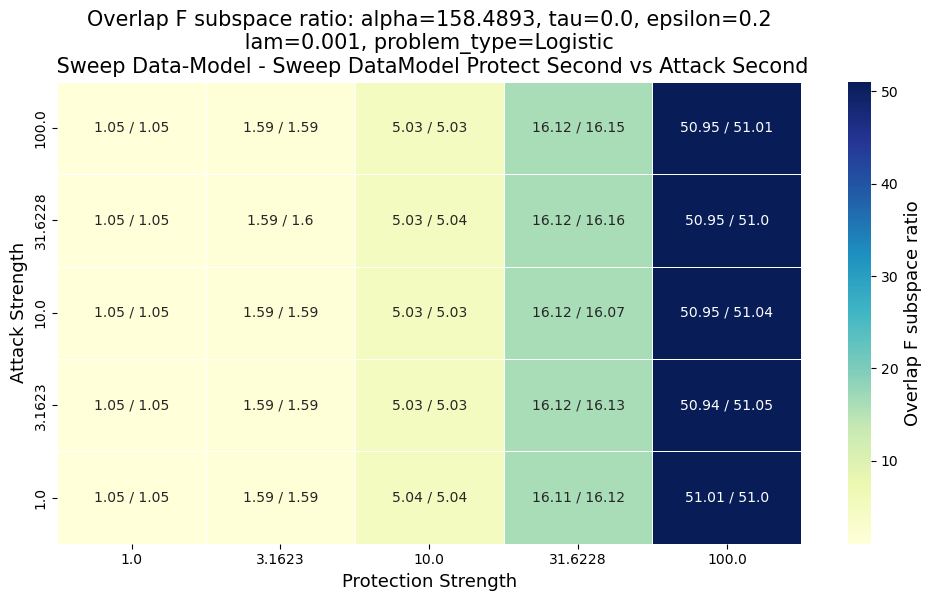

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


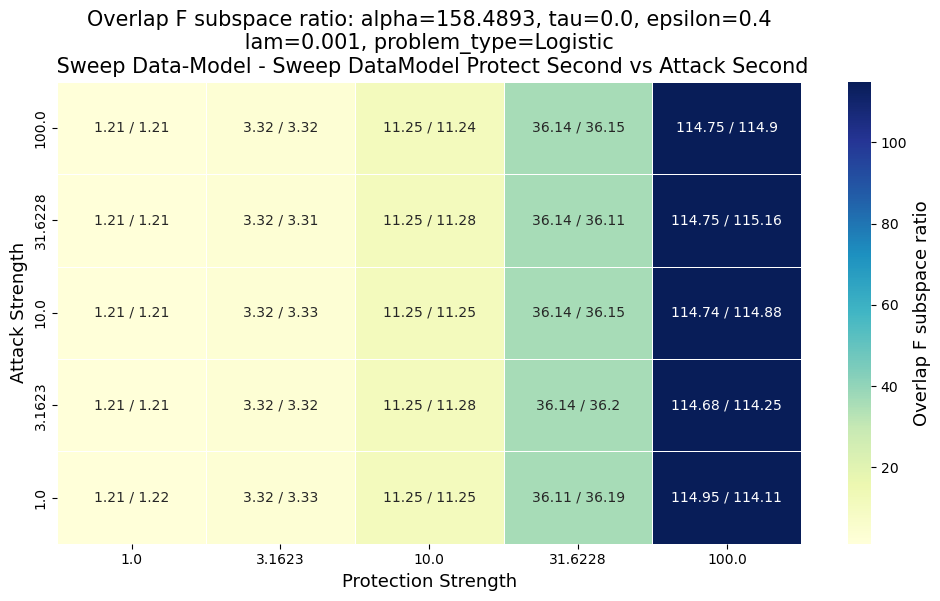

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


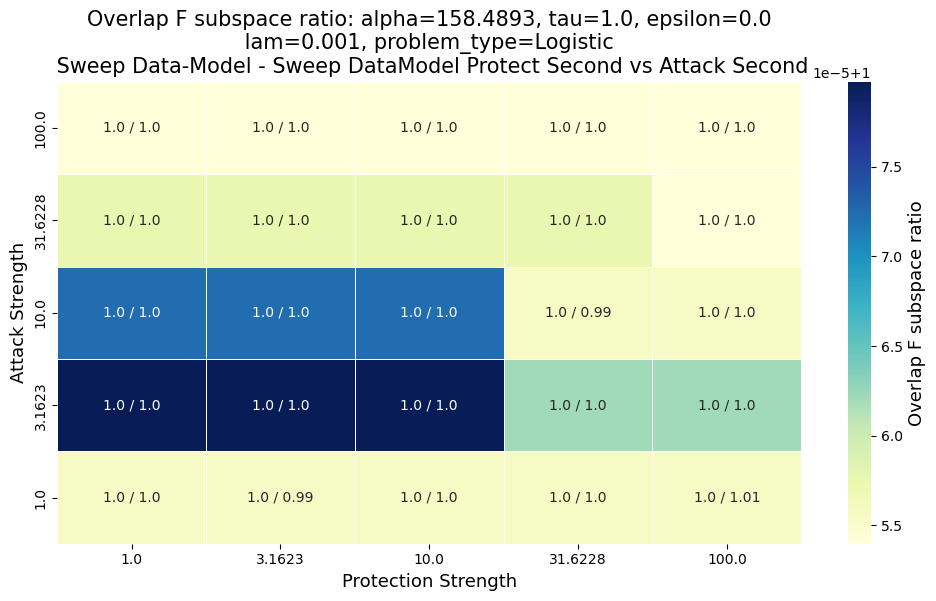

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


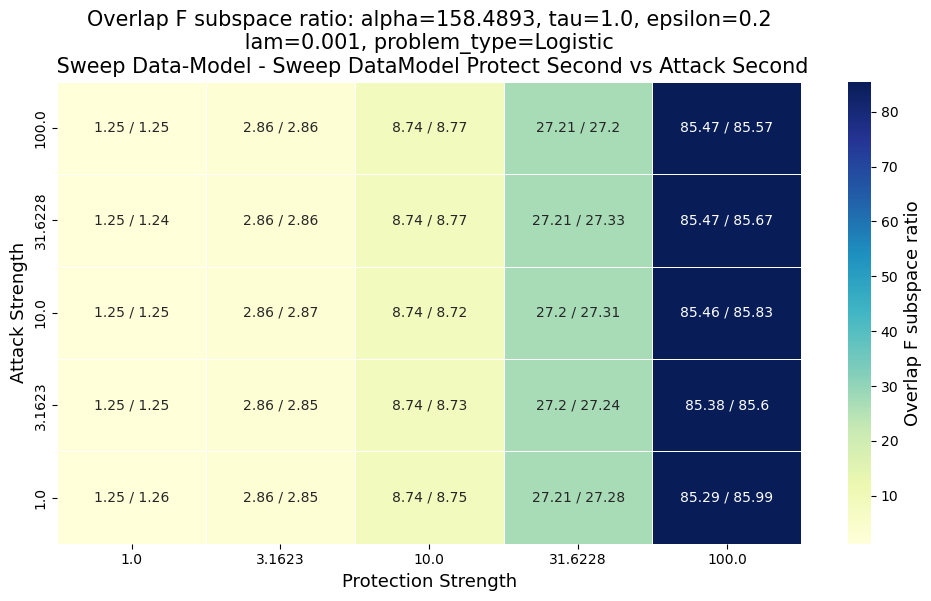

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


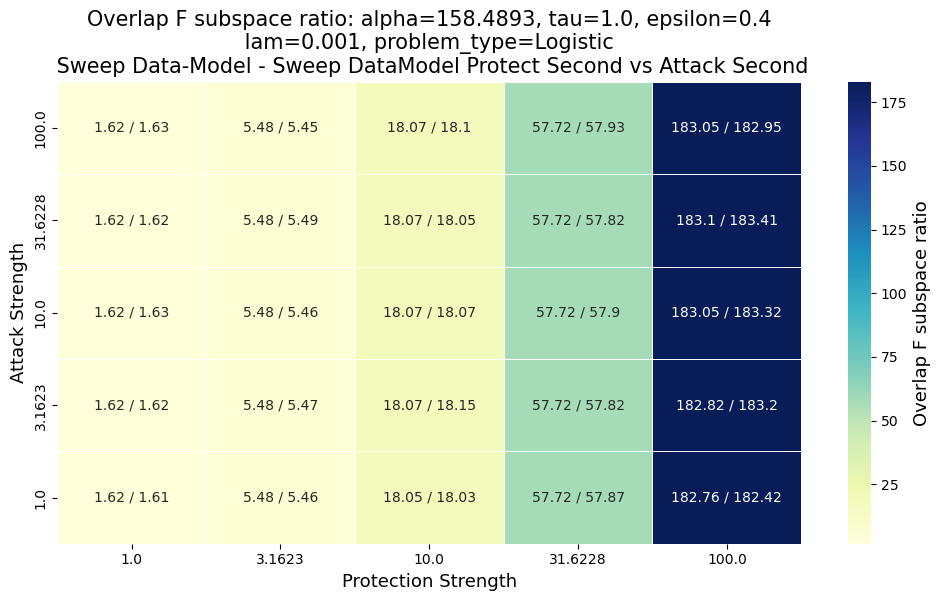

In [332]:
create_plot(df, "Overlap F subspace ratio", "F_subspace_ratio")

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


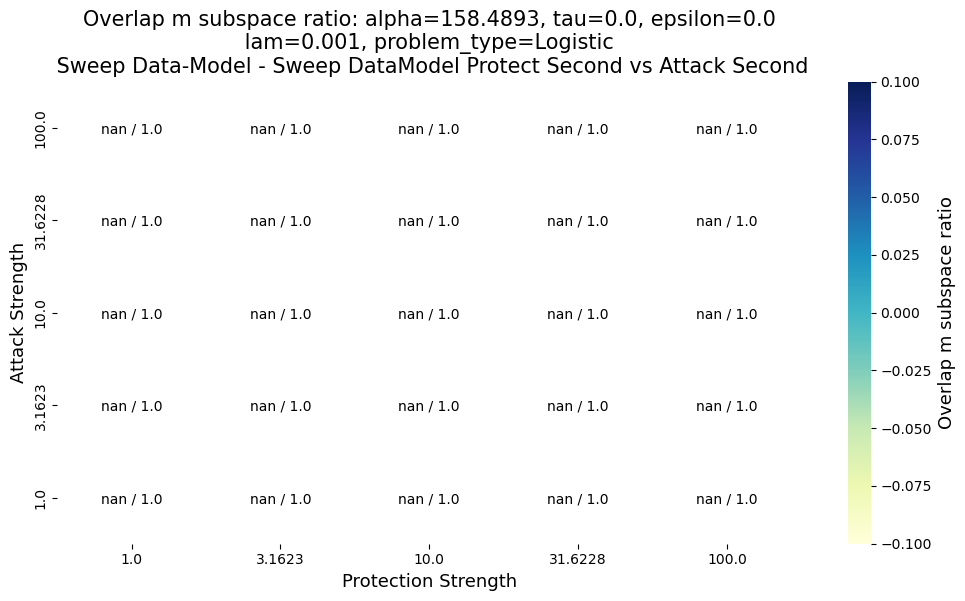

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


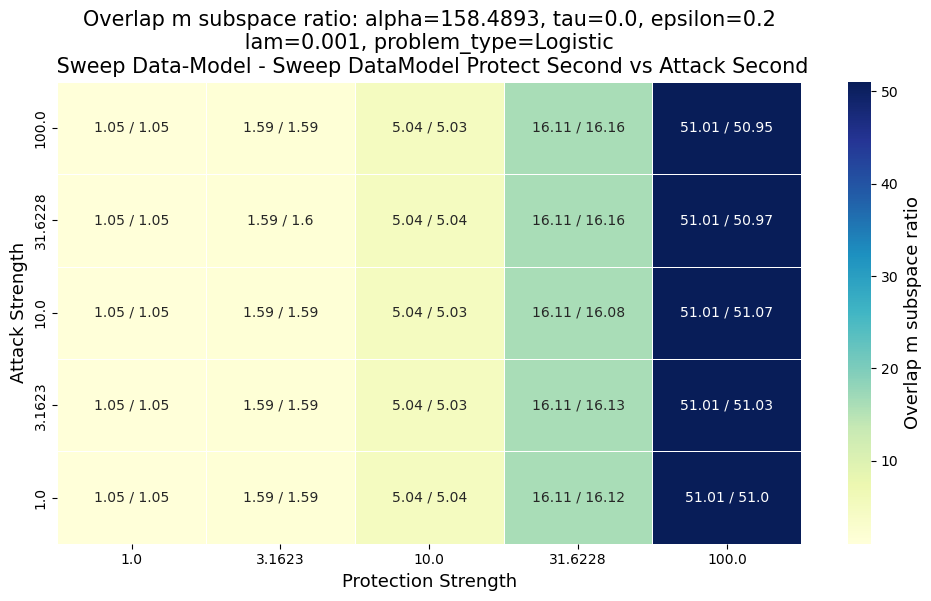

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


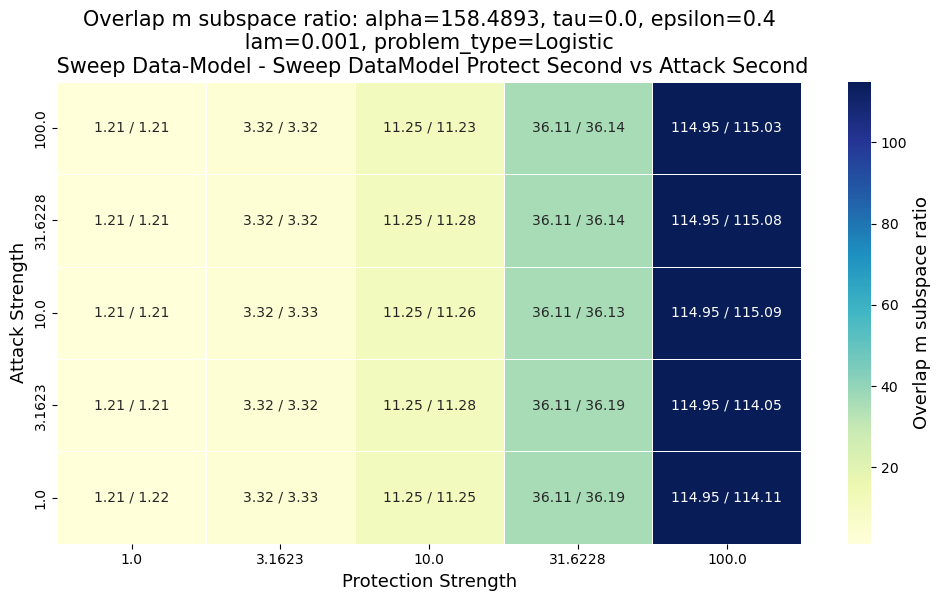

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


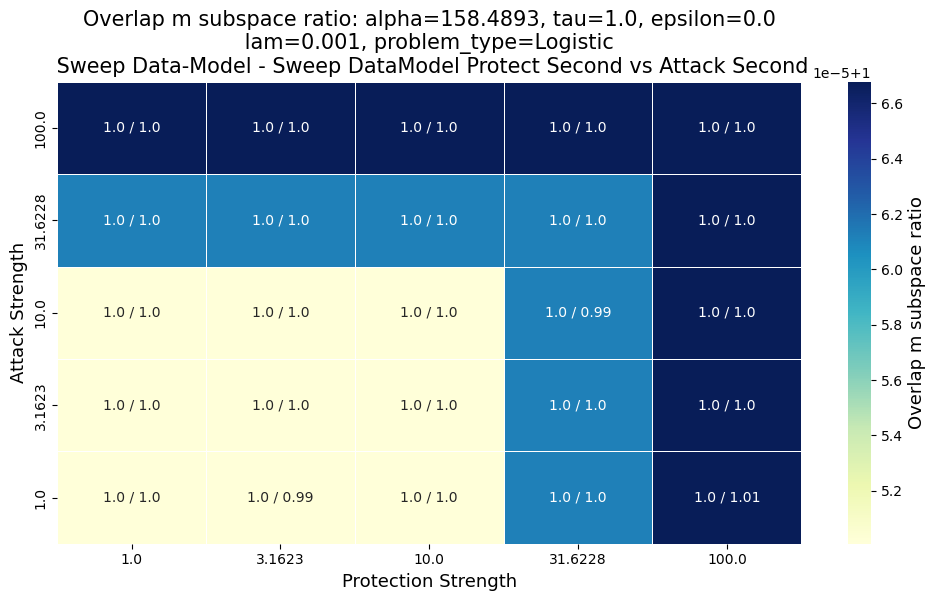

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


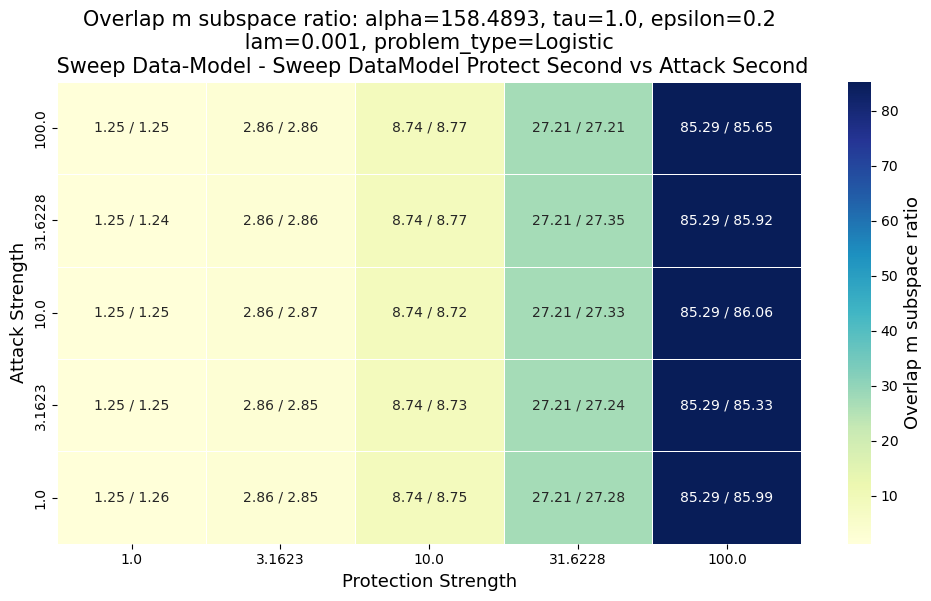

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


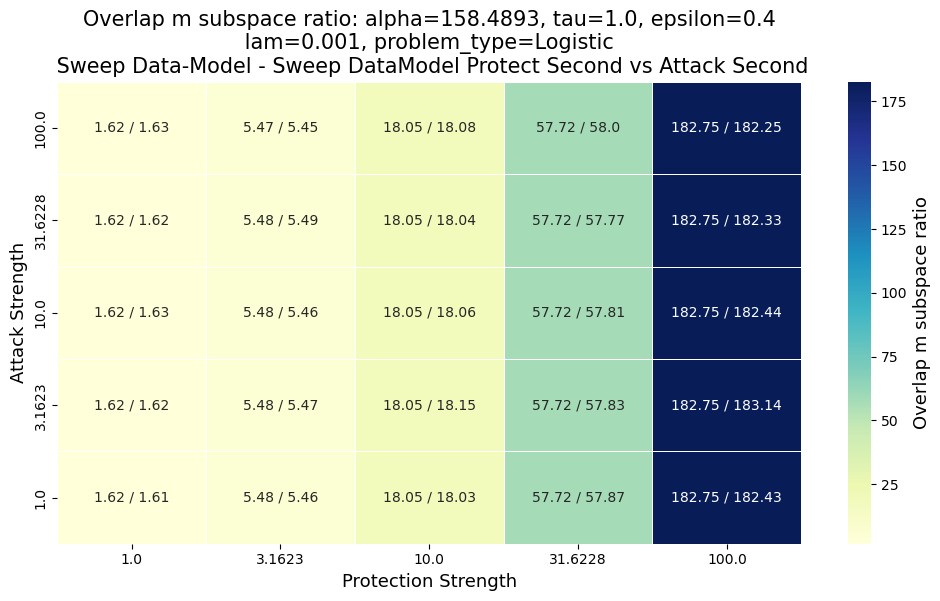

In [333]:
create_plot(df, "Overlap m subspace ratio", "m_subspace_ratio")

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


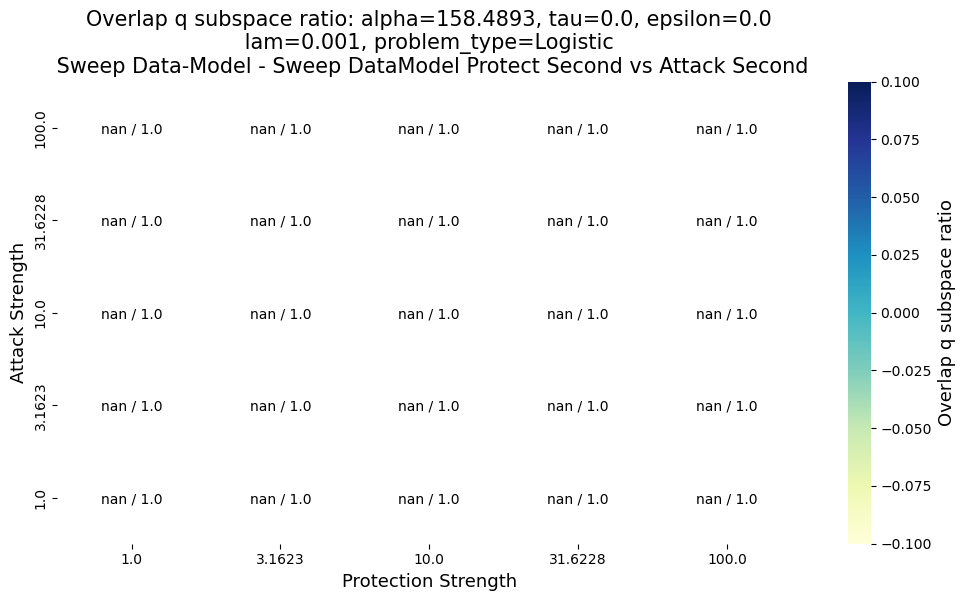

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


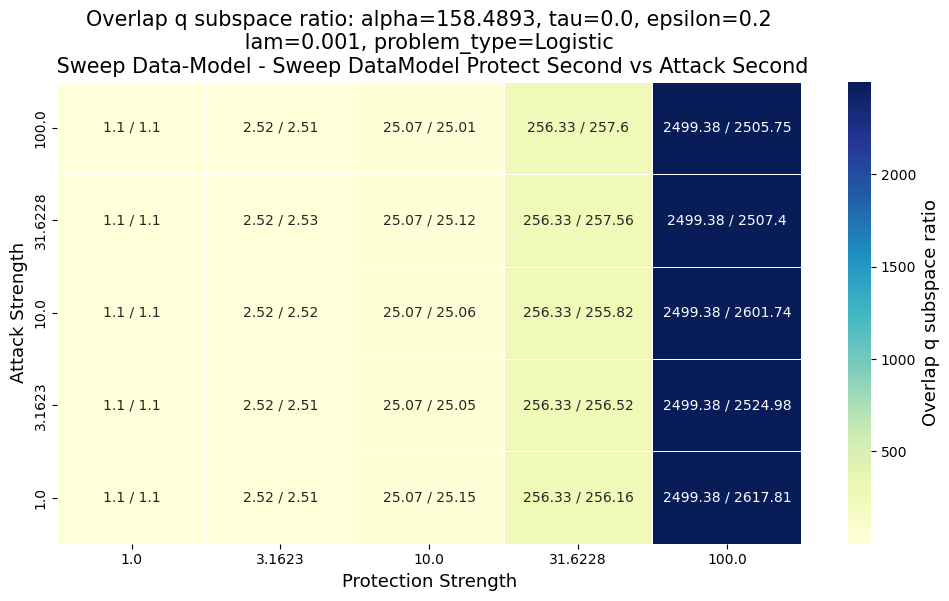

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


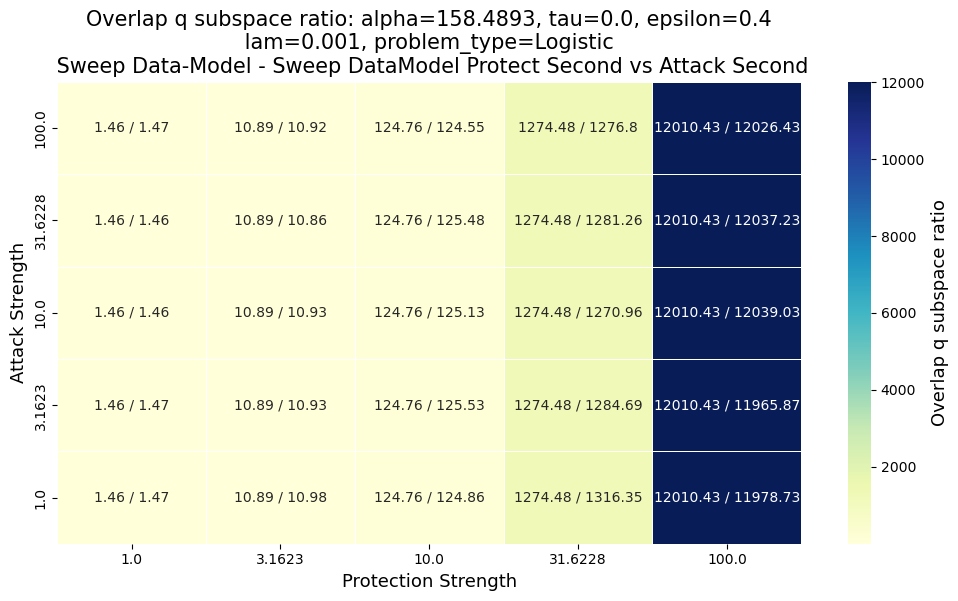

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


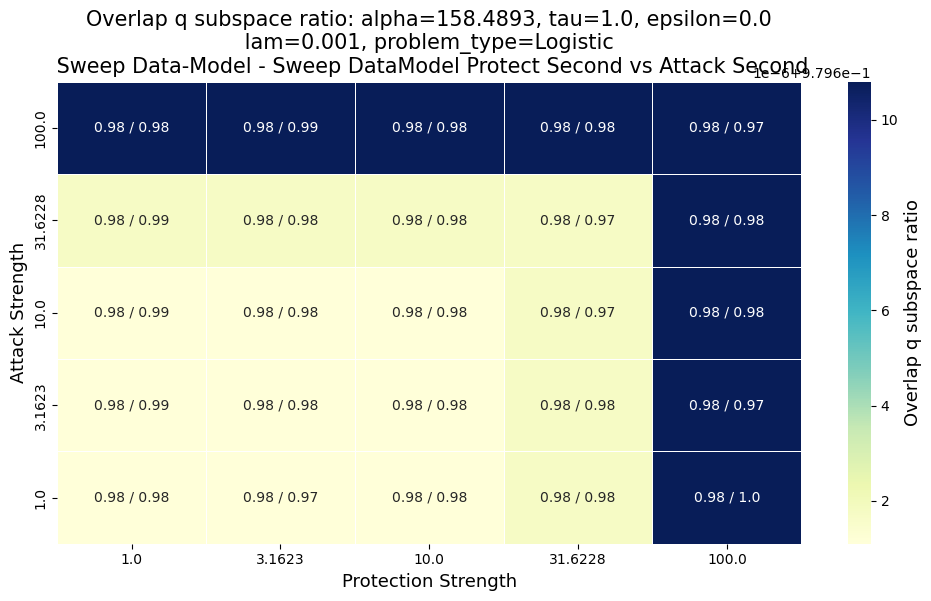

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


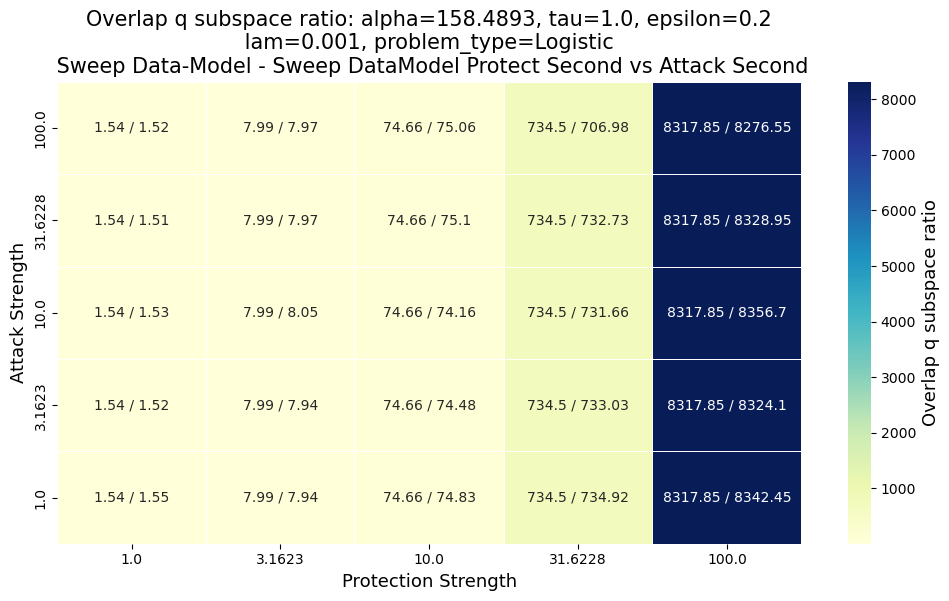

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


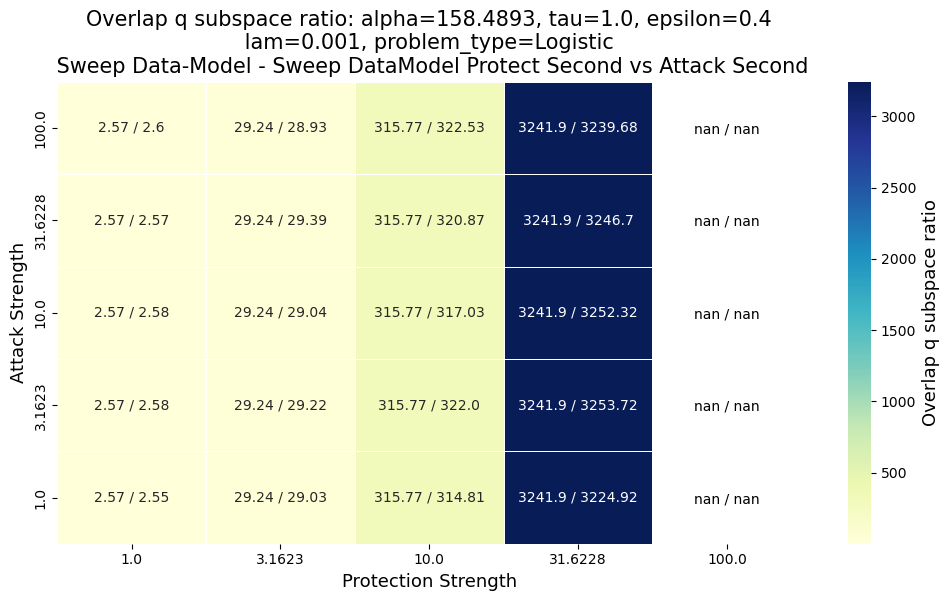

In [334]:
create_plot(df, "Overlap q subspace ratio", "q_subspace_ratio")

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


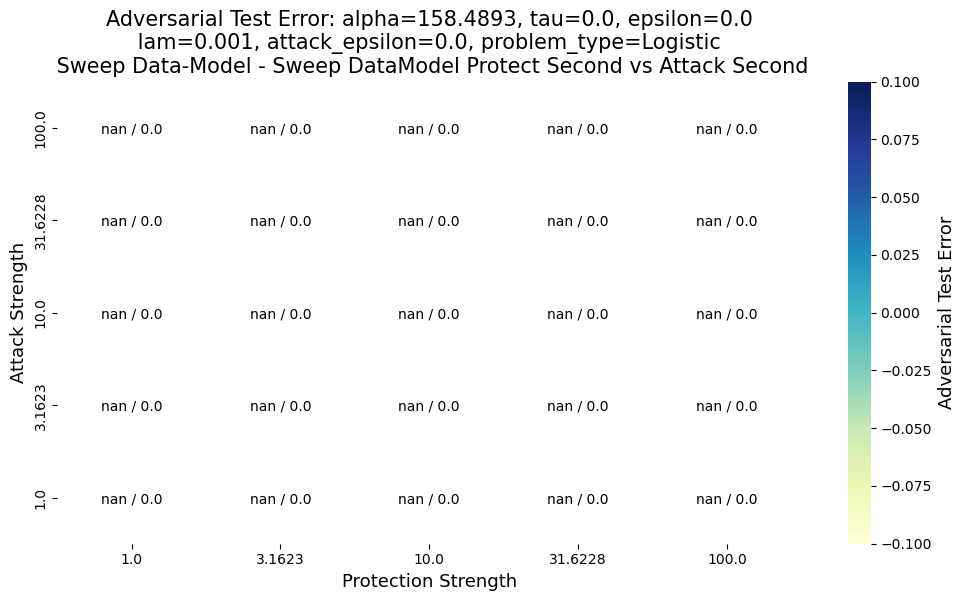

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


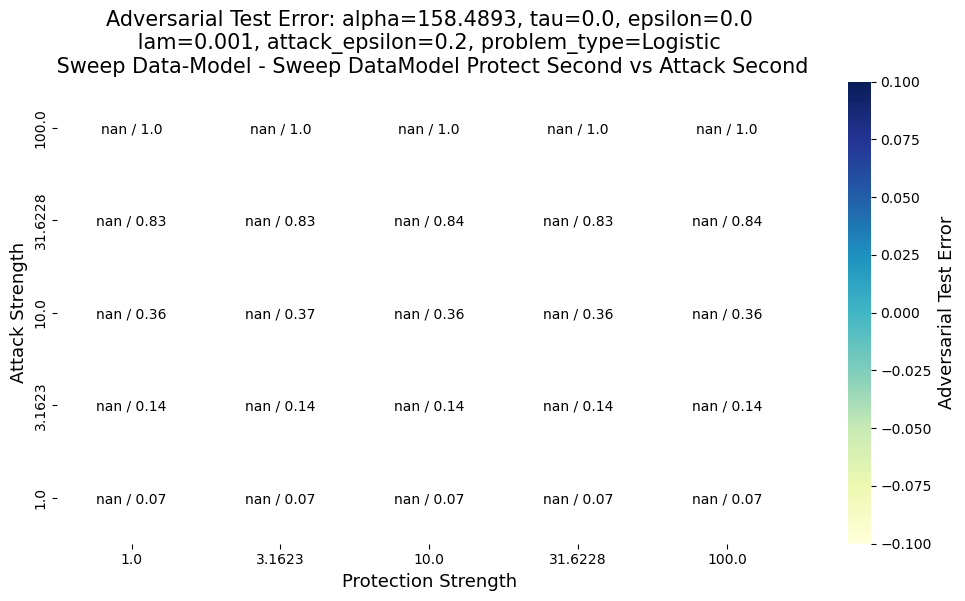

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


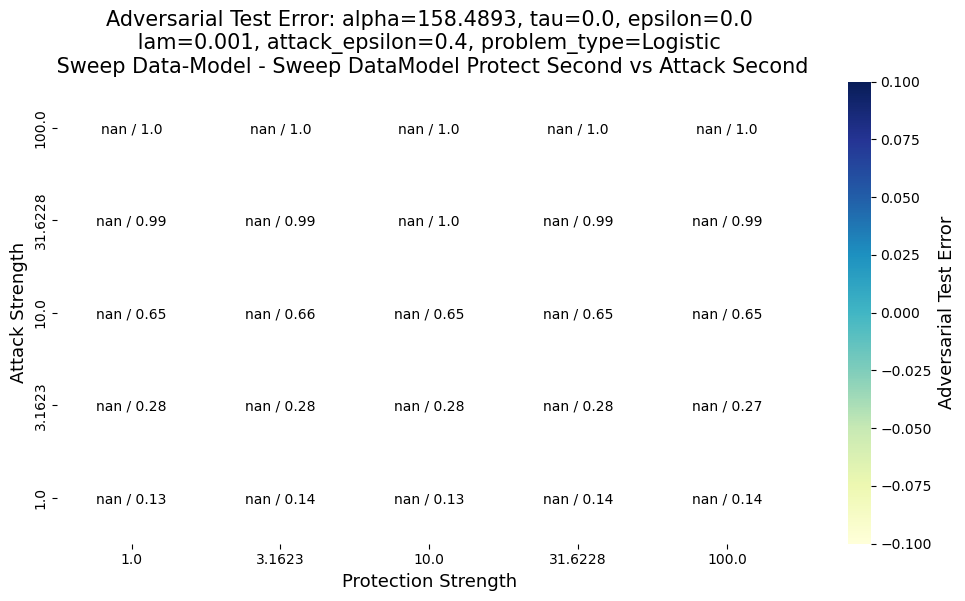

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


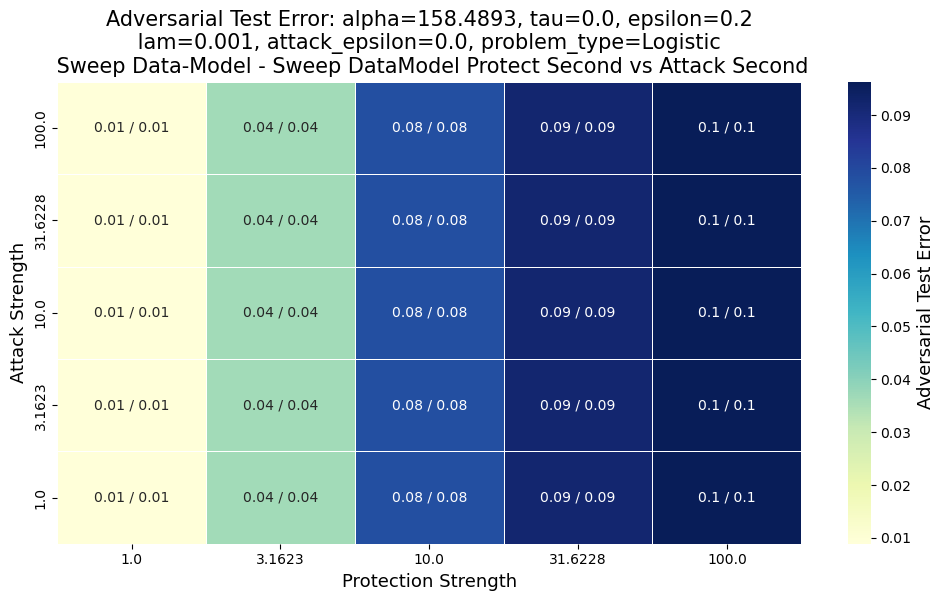

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


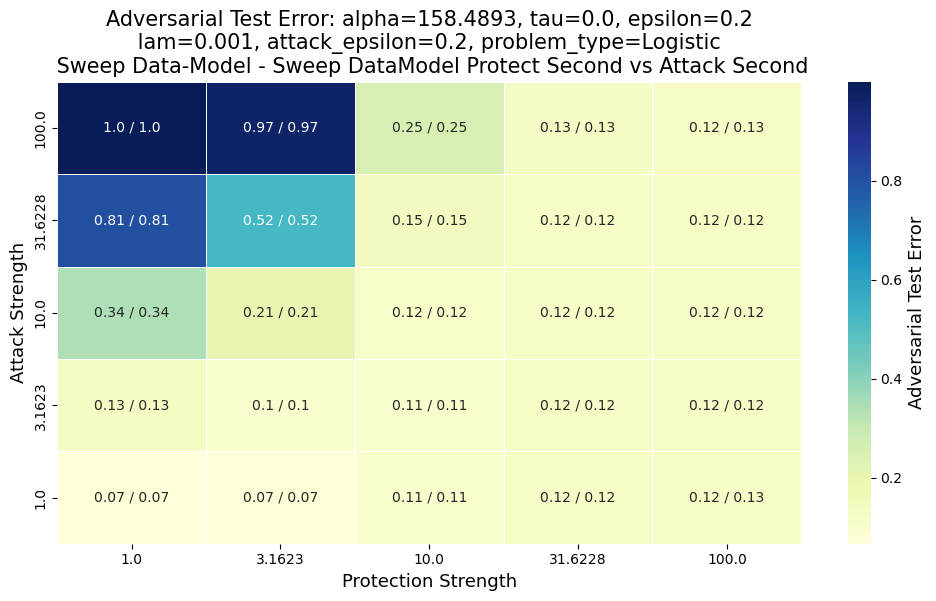

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


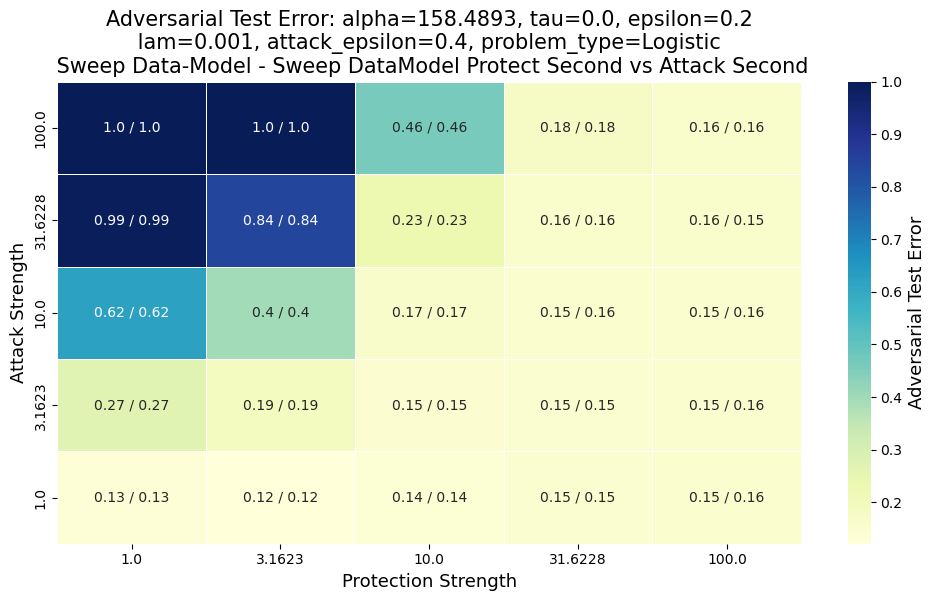

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


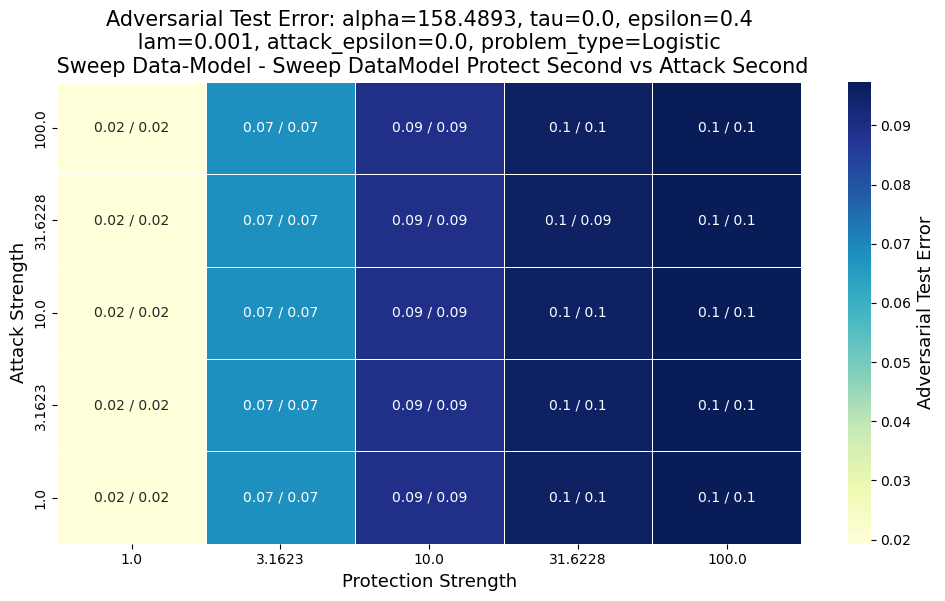

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


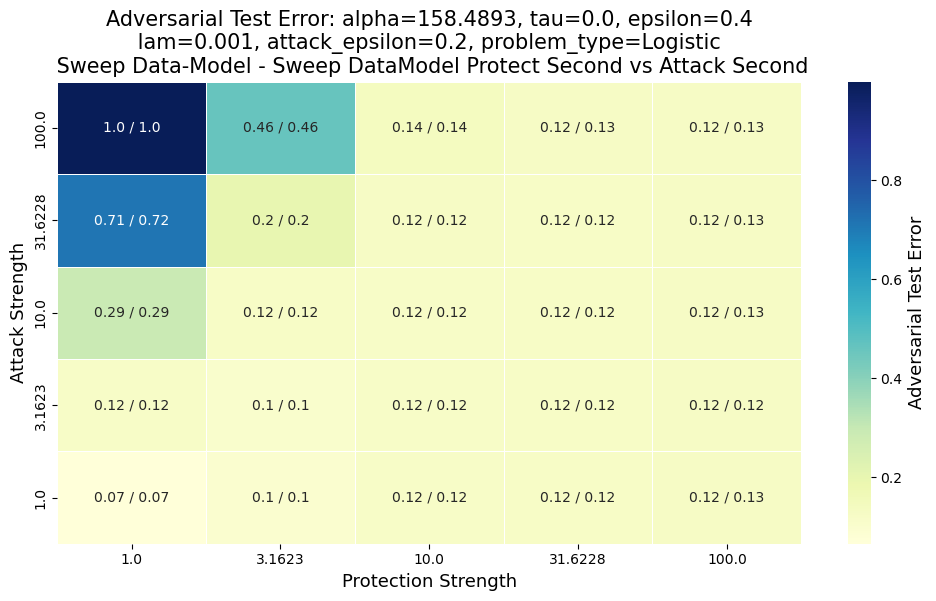

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


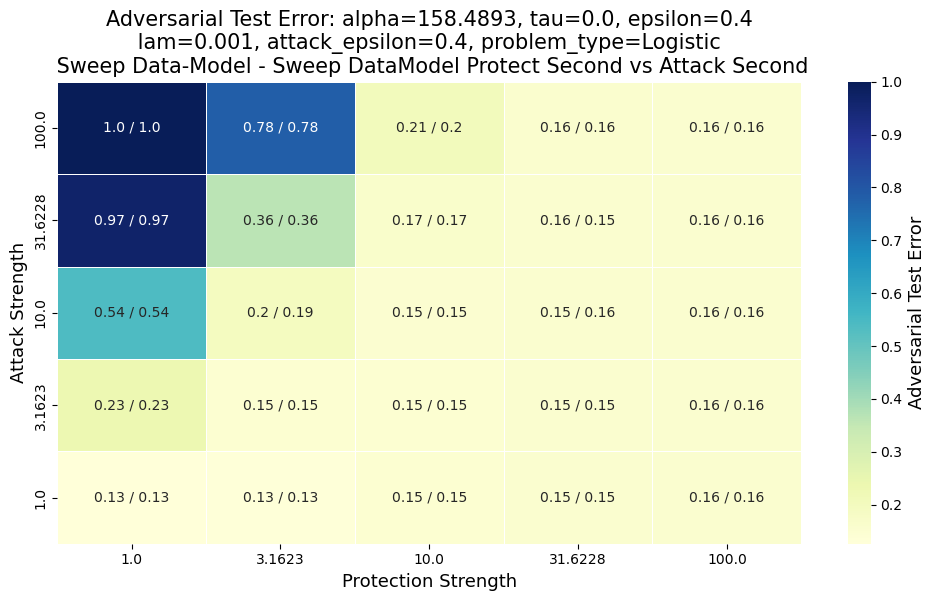

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


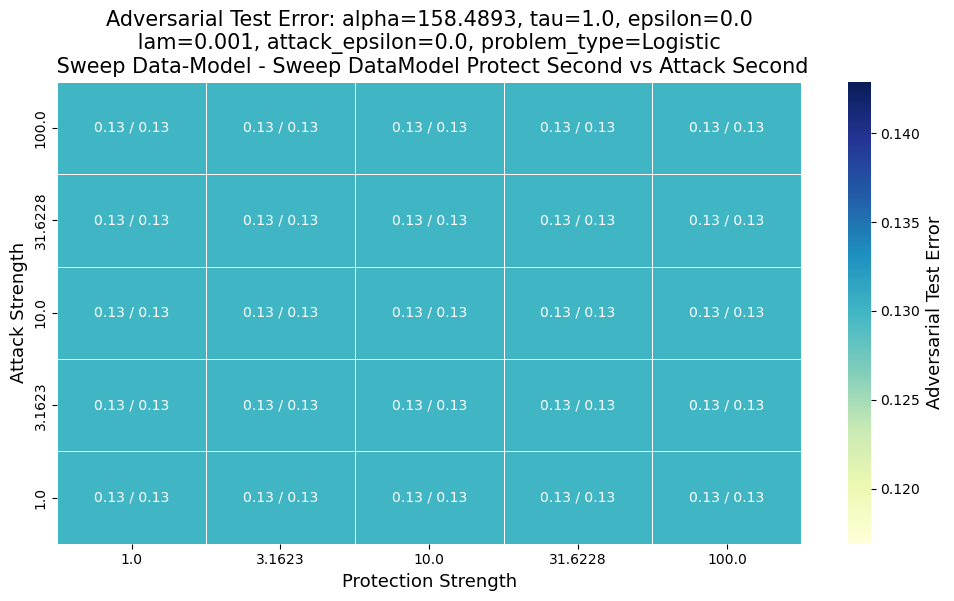

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


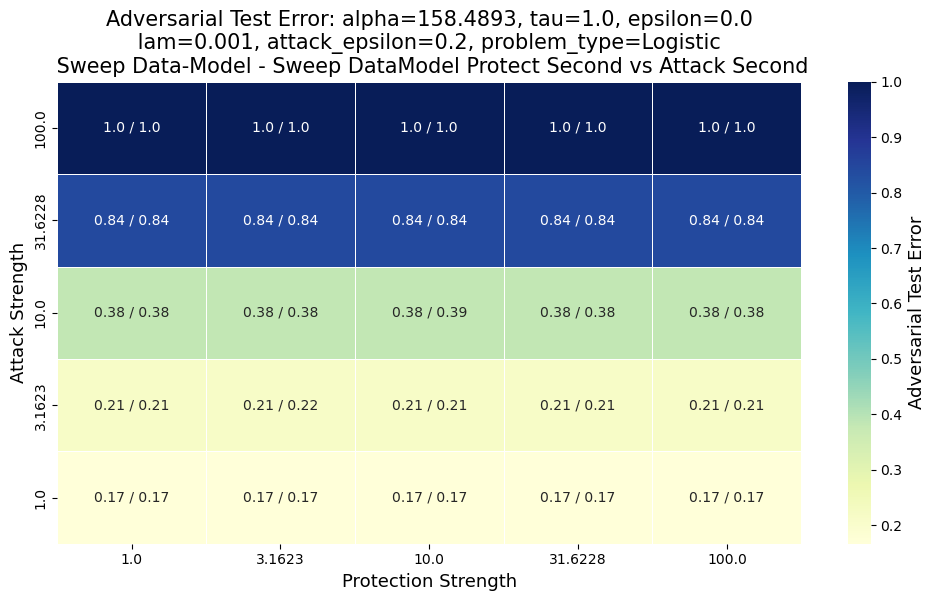

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


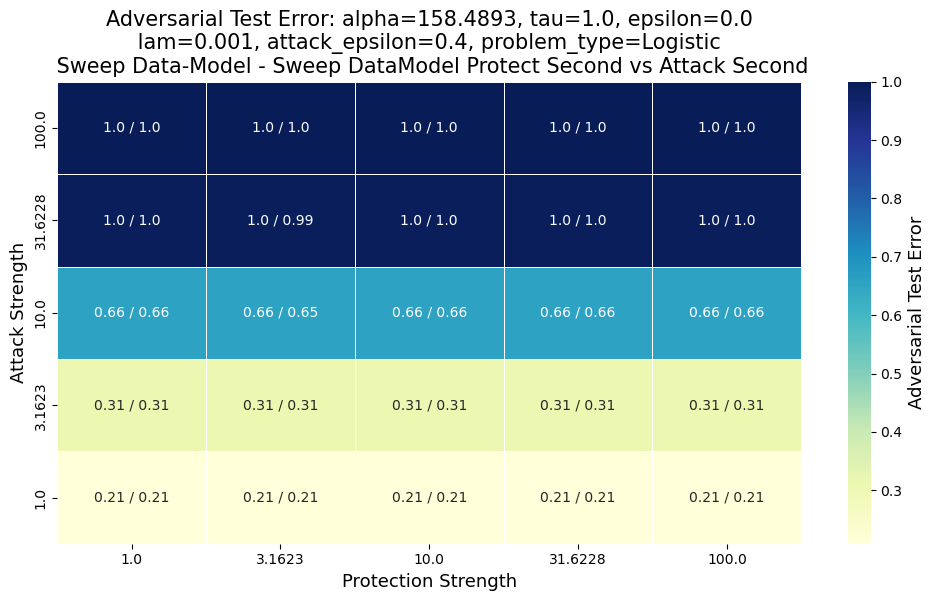

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


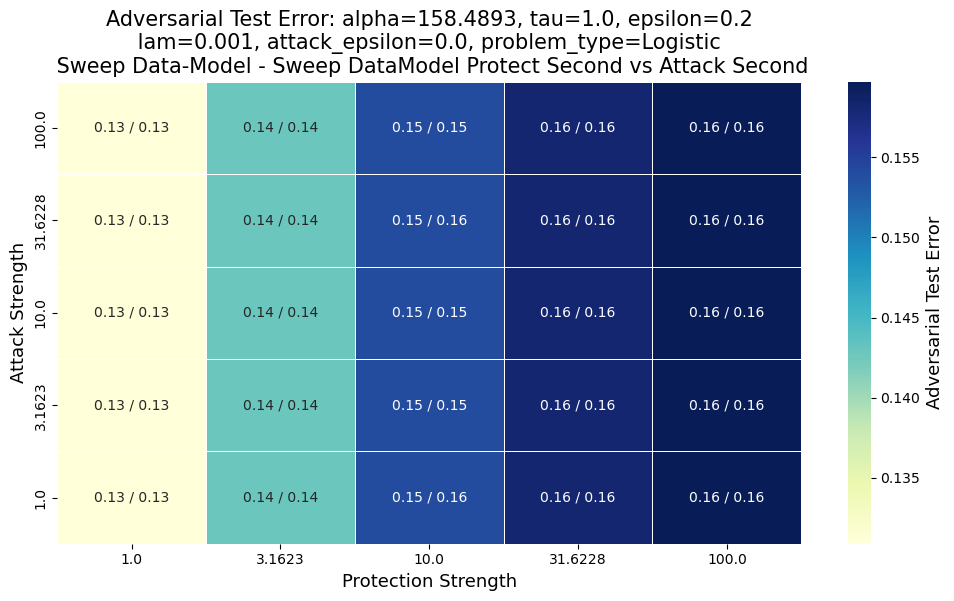

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


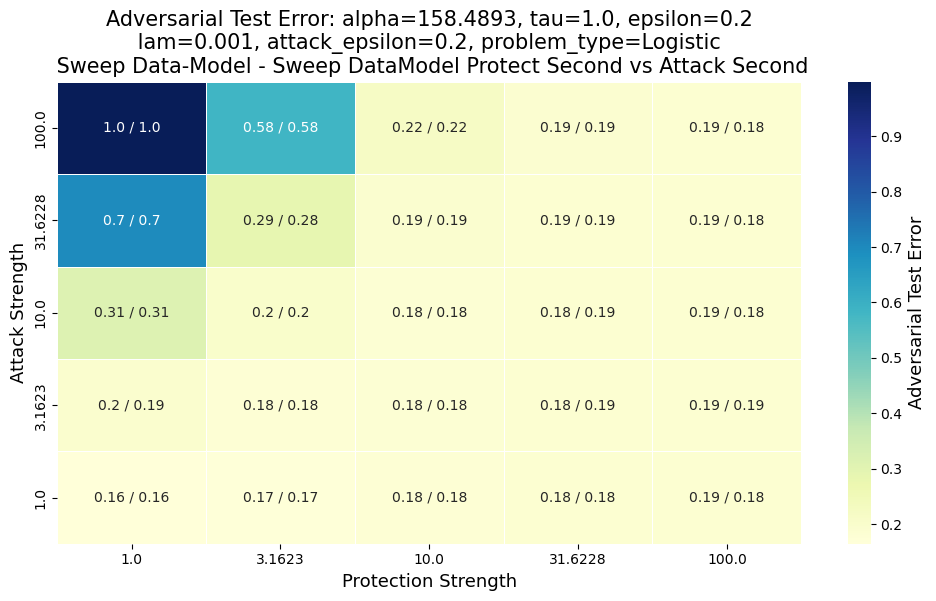

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


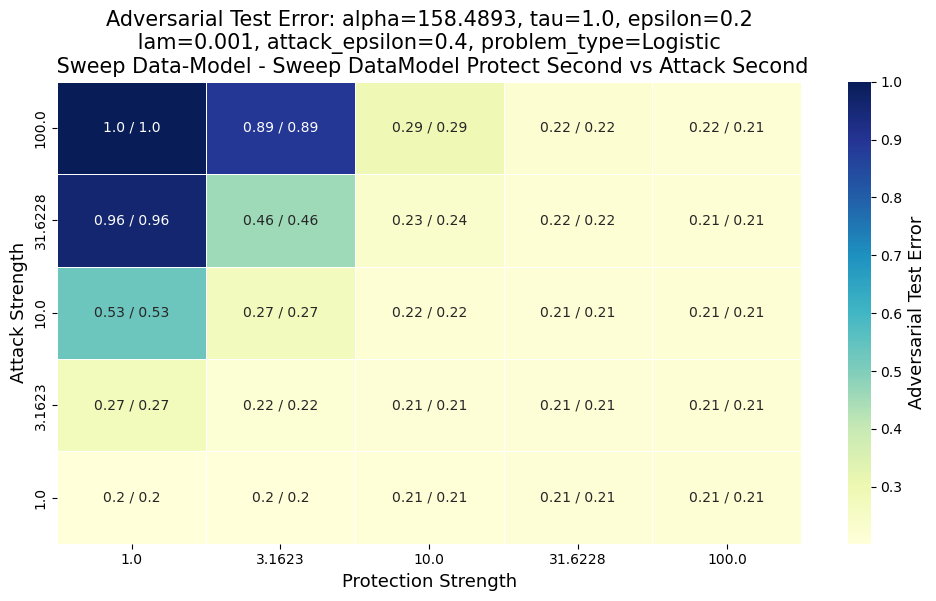

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


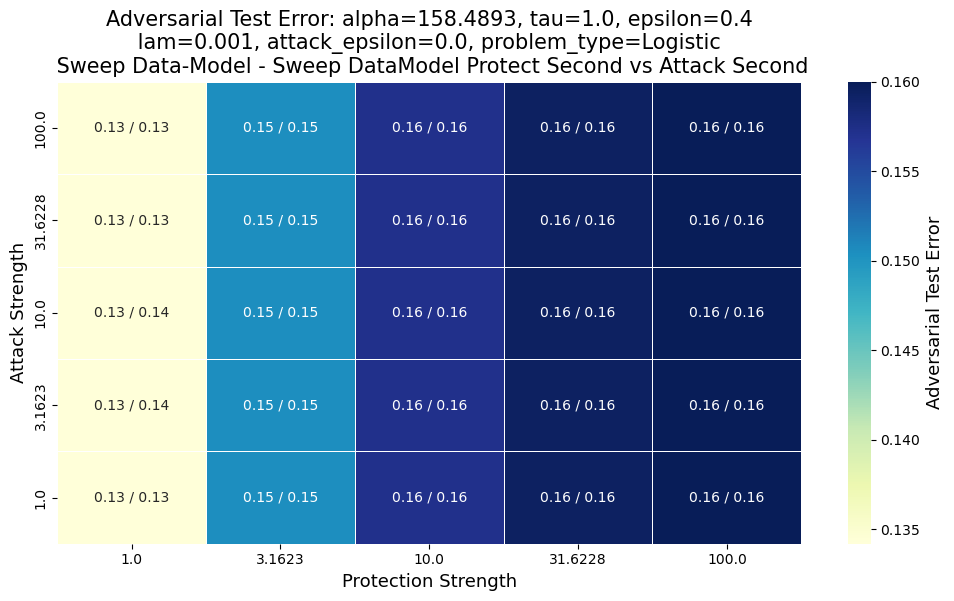

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


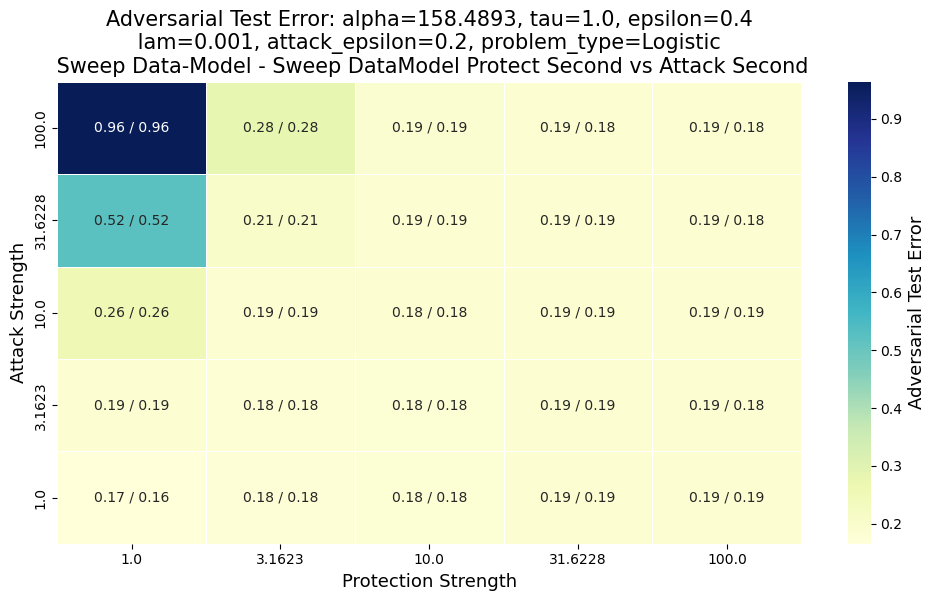

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


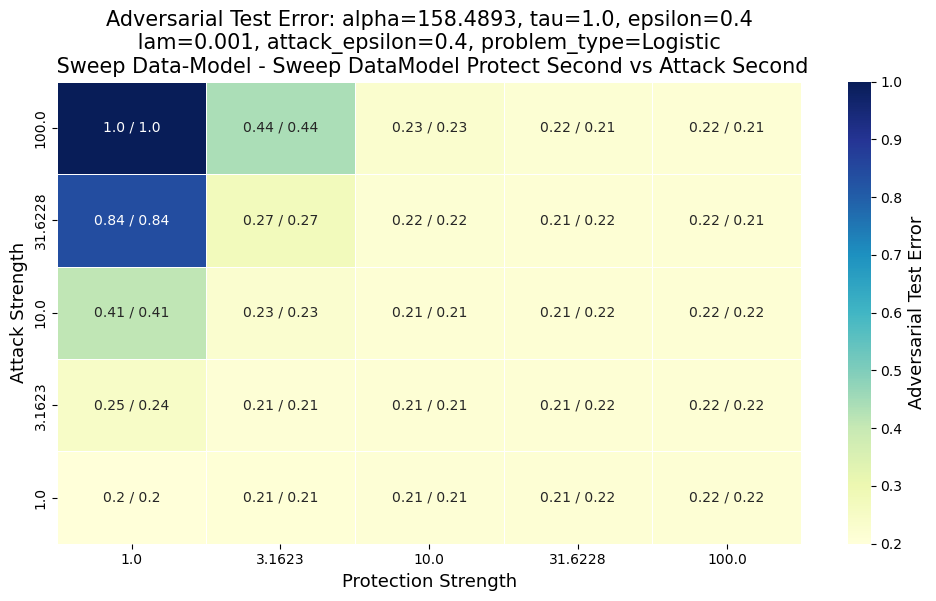

In [335]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error", iterate_attack_strengths=True, use_mean = True)

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


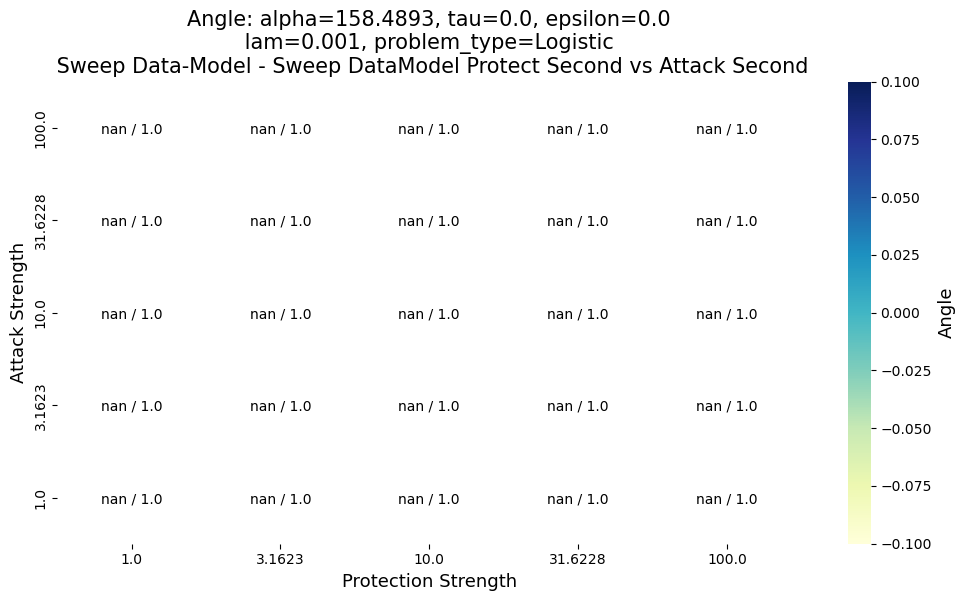

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


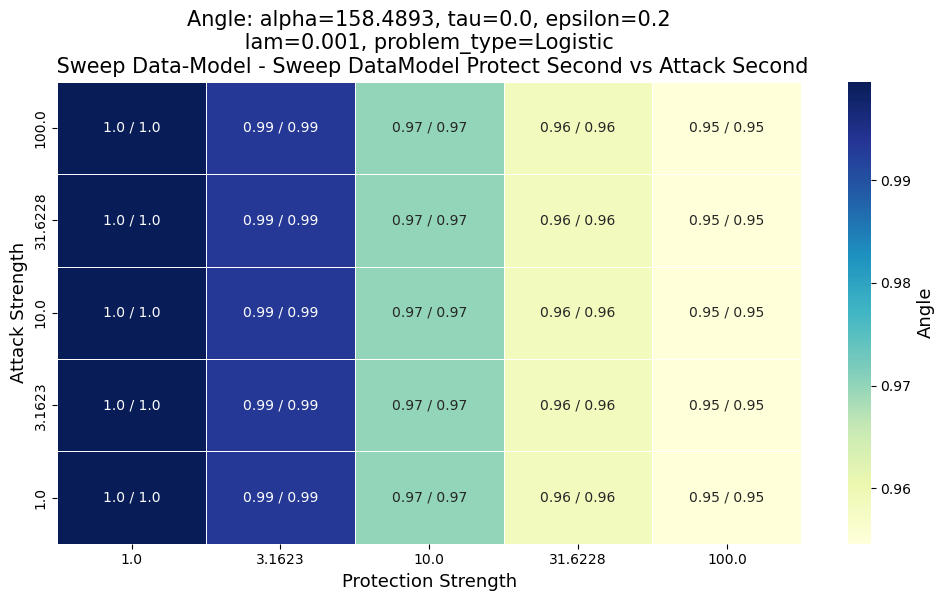

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


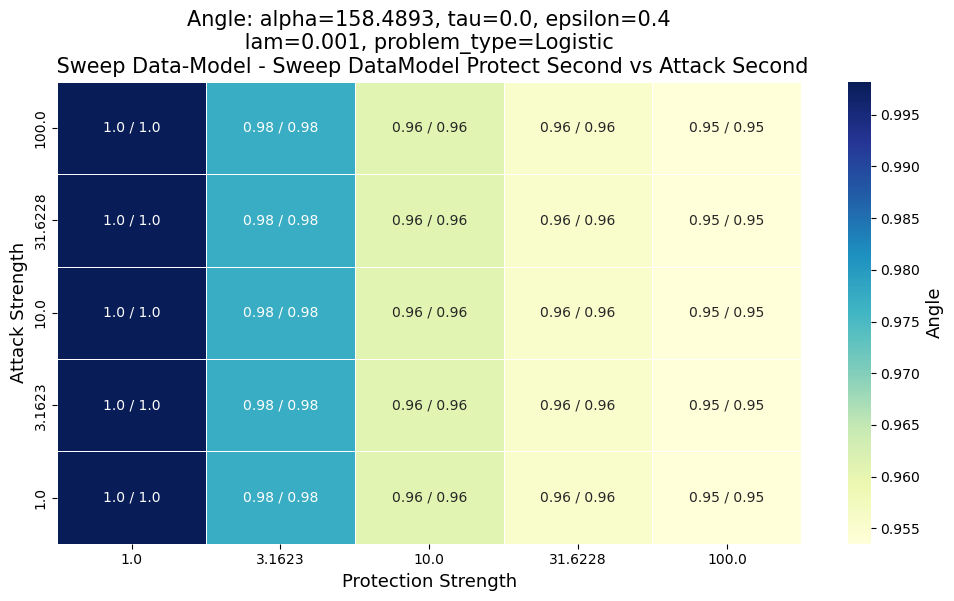

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


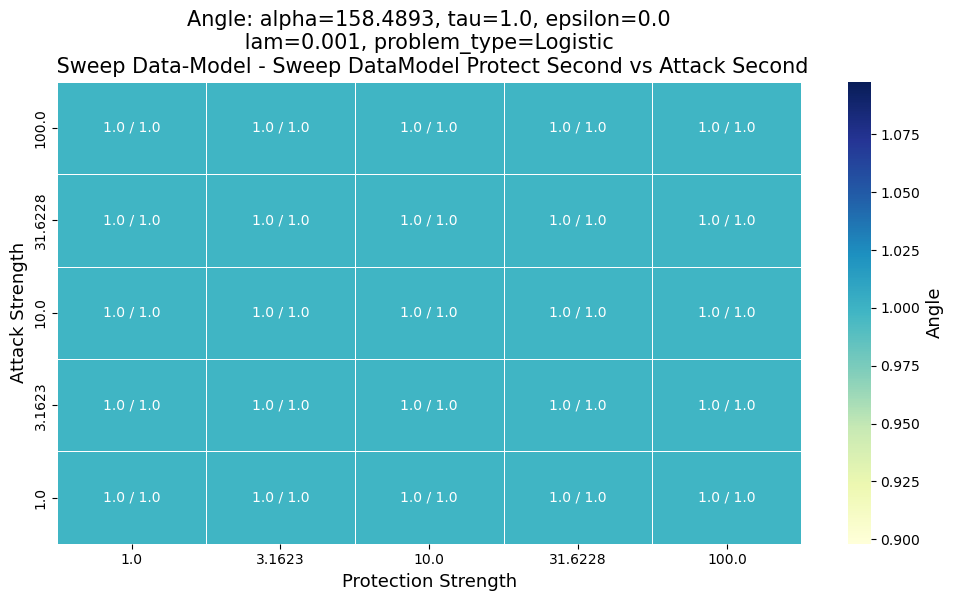

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


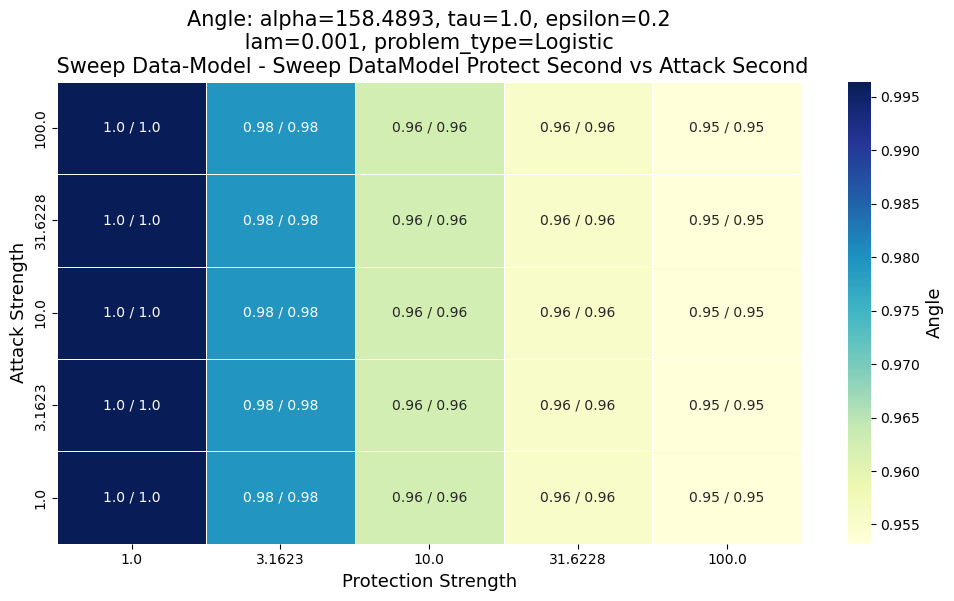

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


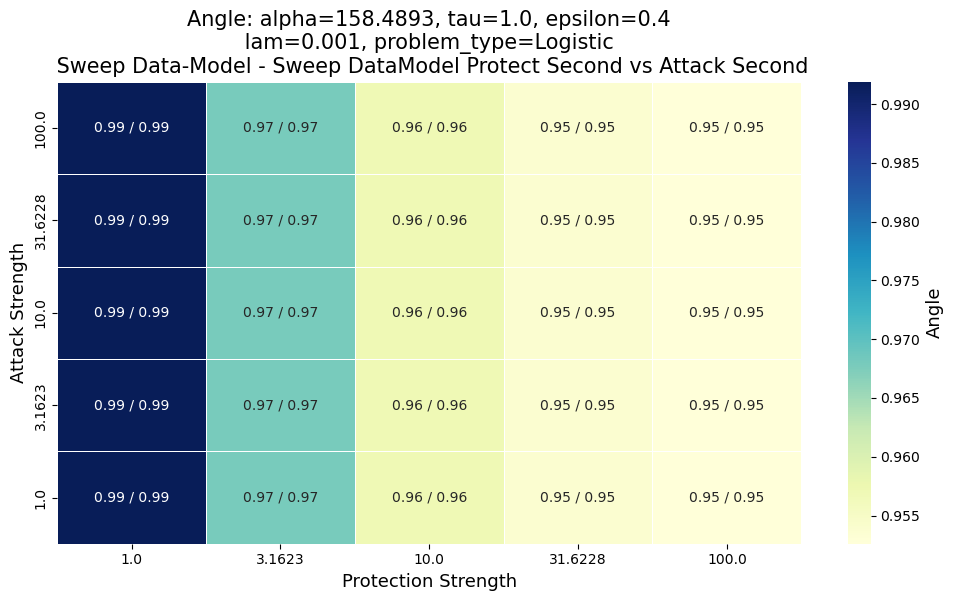

In [336]:
create_plot(df, "Angle", "angle", use_mean = True)

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


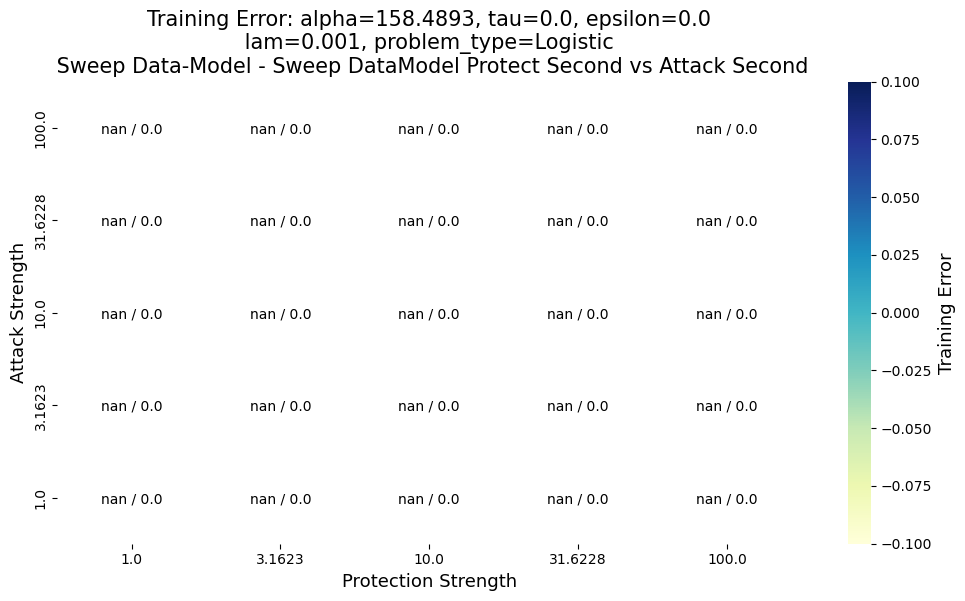

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


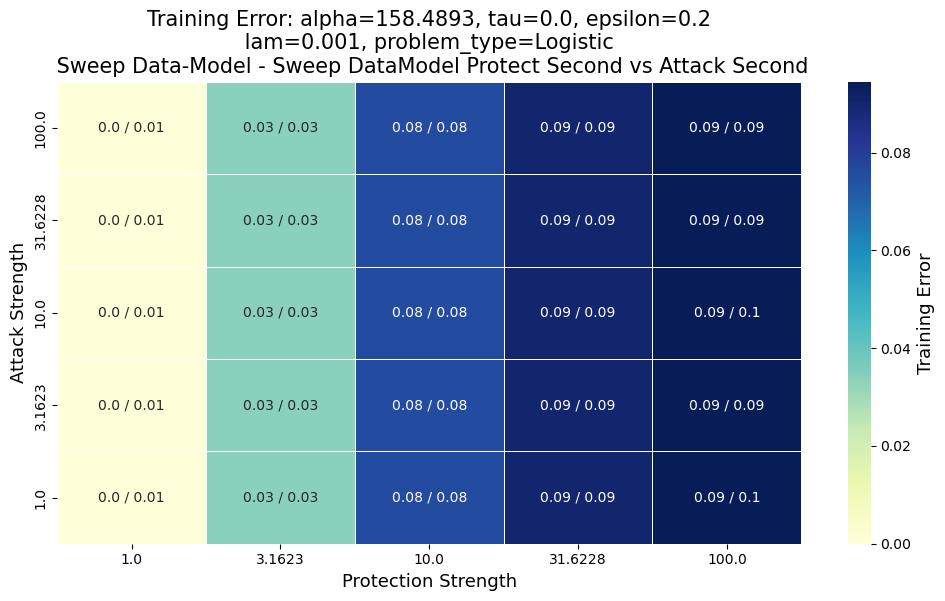

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


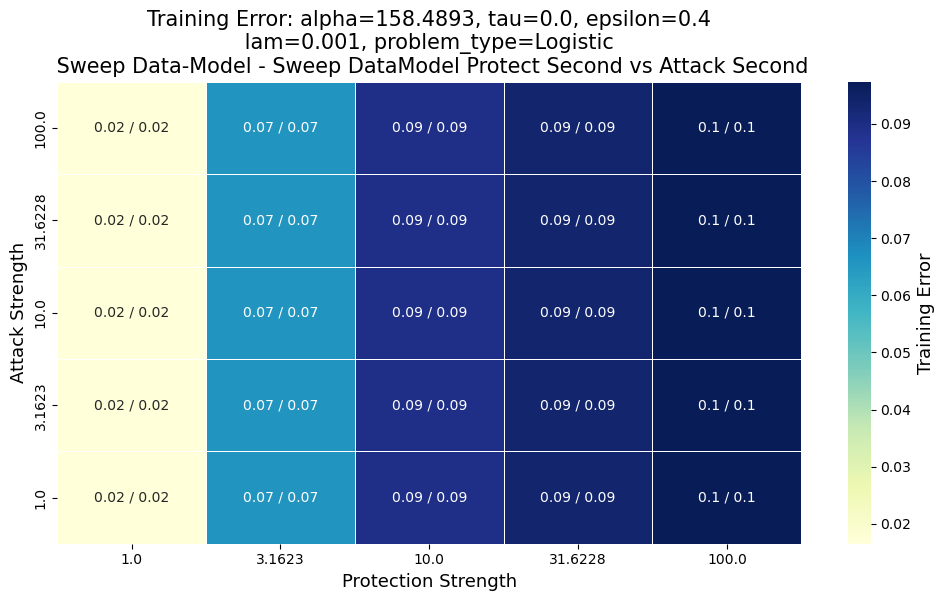

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


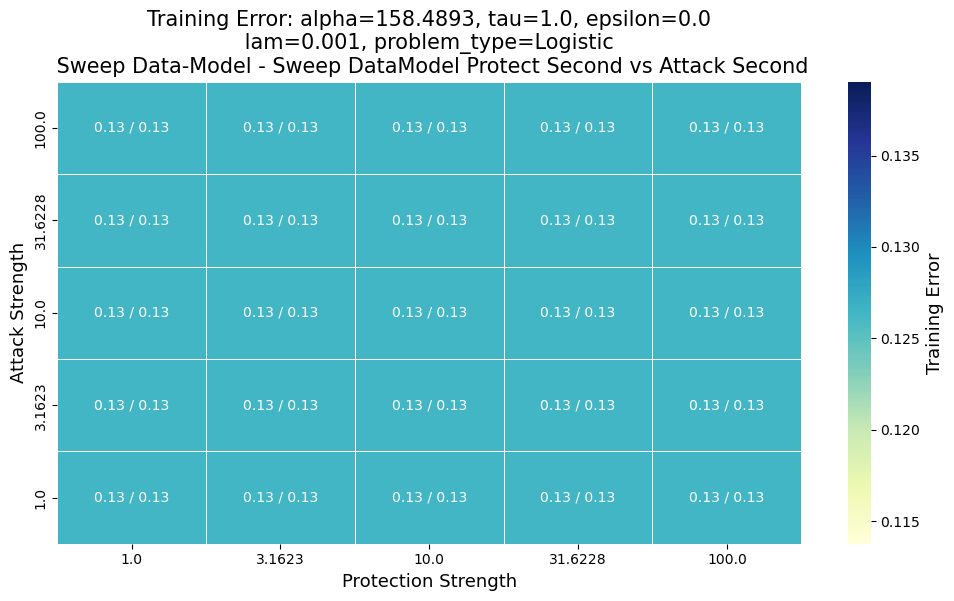

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


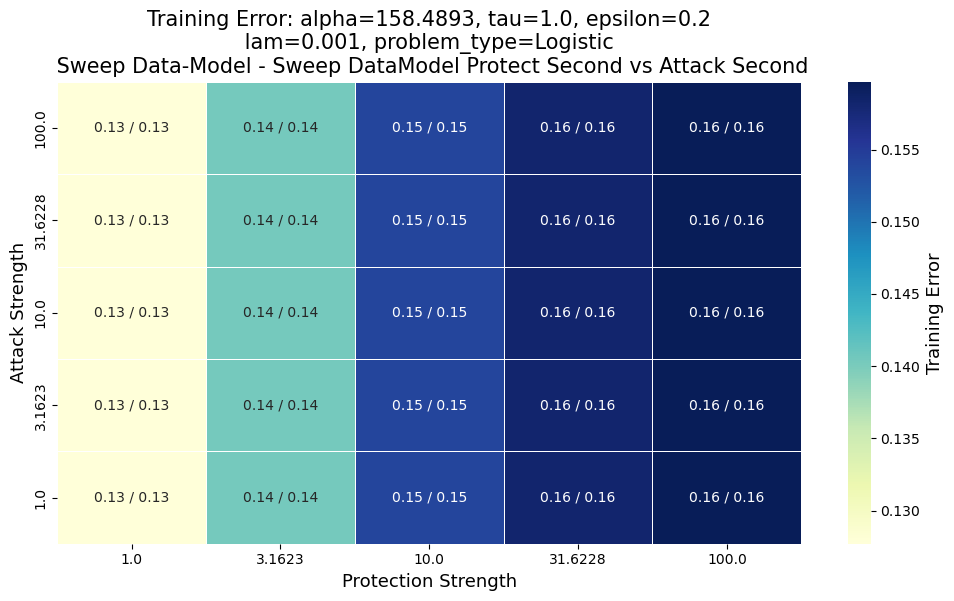

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  None  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


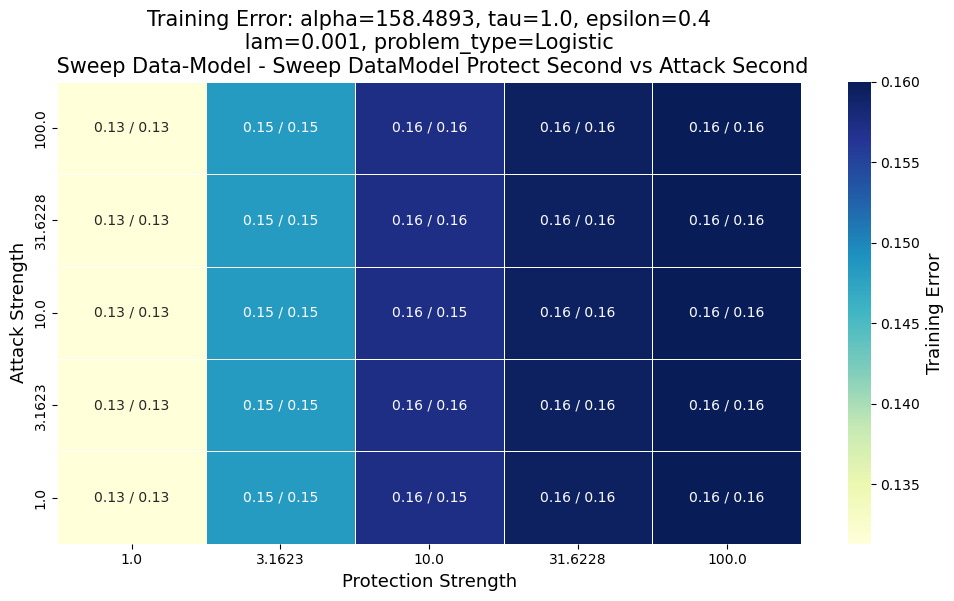

In [337]:
create_plot(df, "Training Error", "training_error", use_mean = True)

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


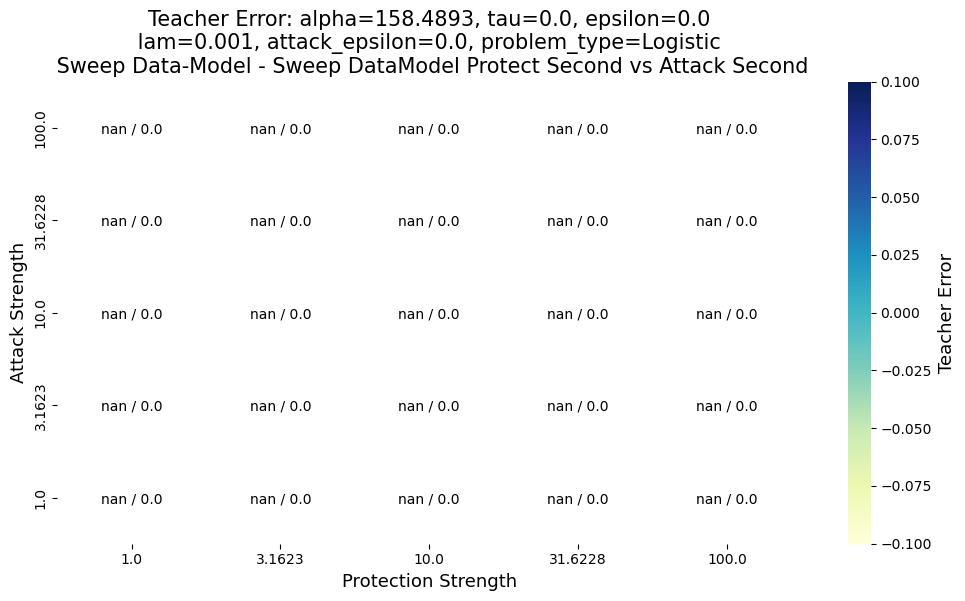

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


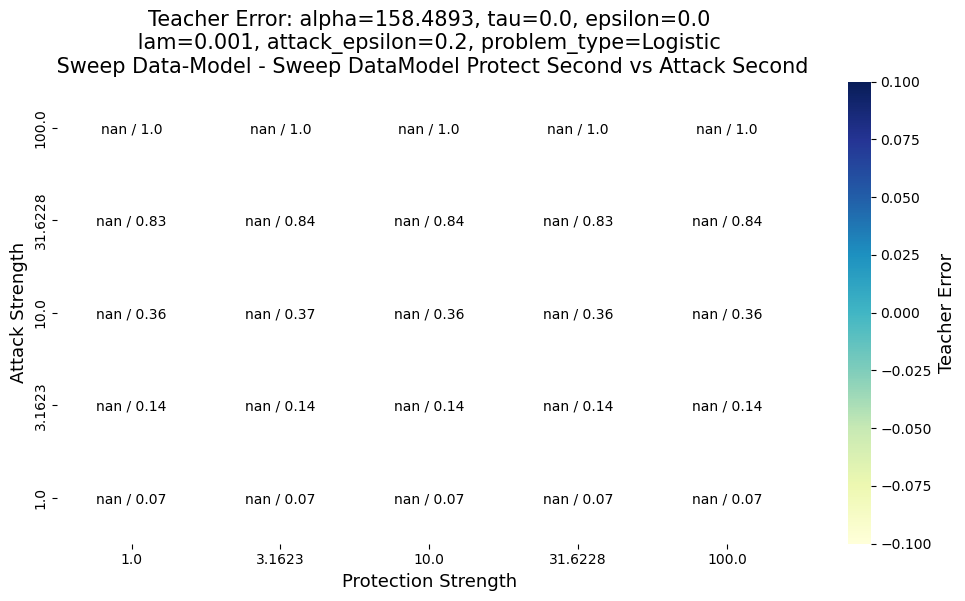

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


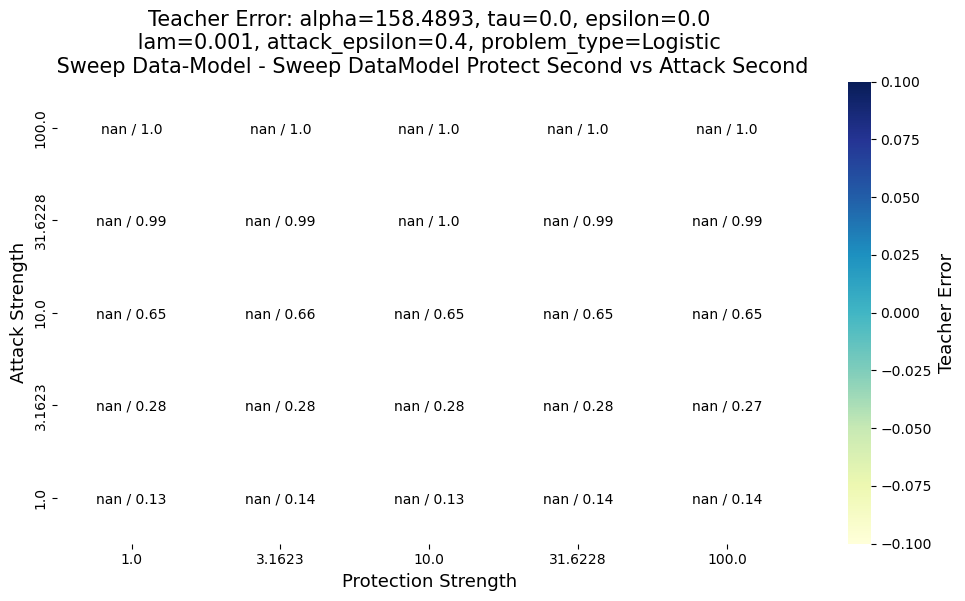

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


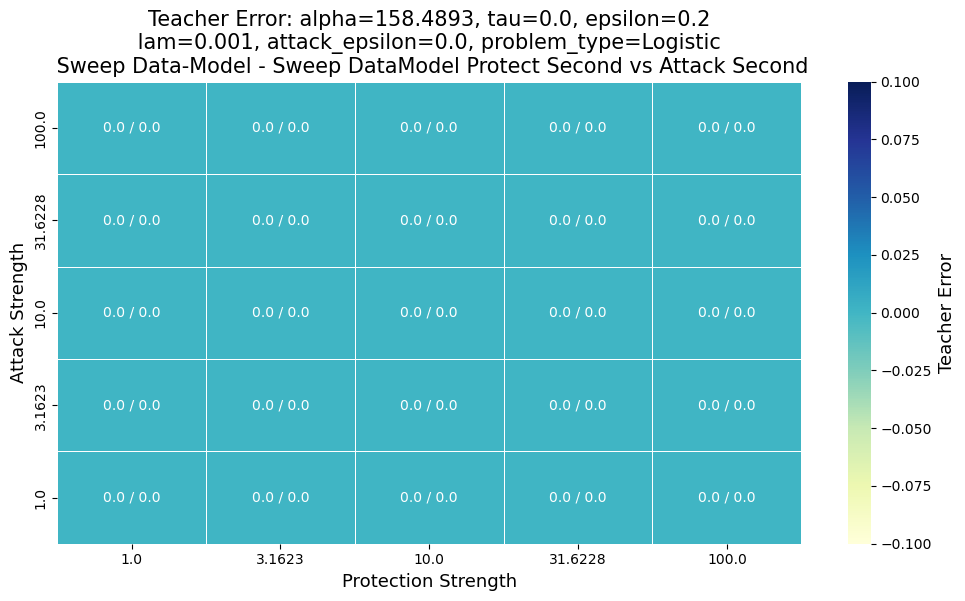

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


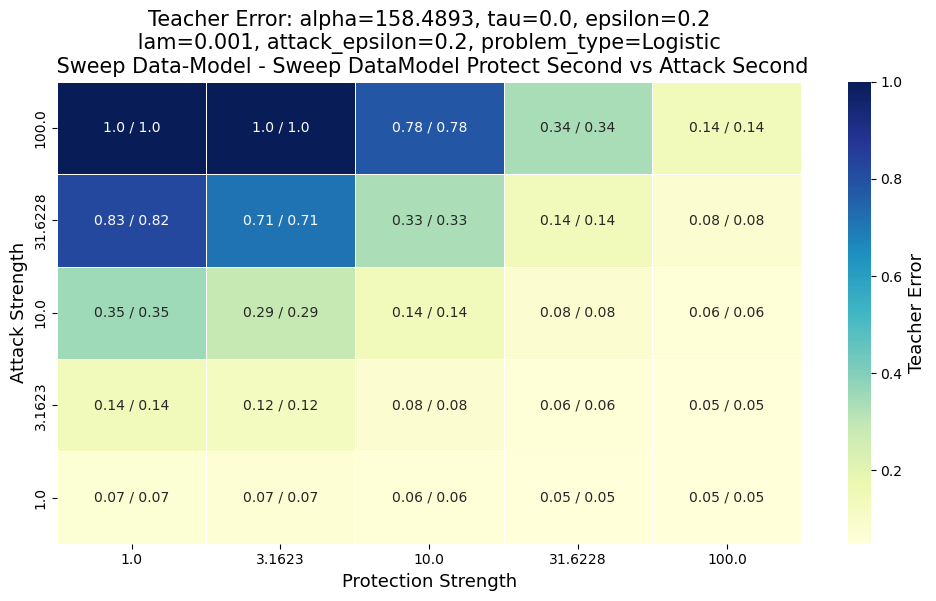

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


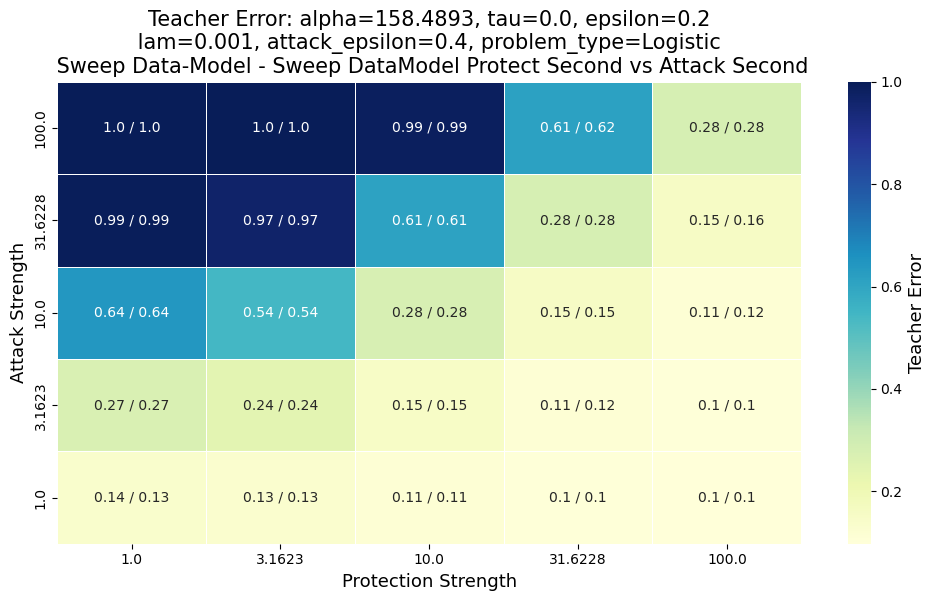

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


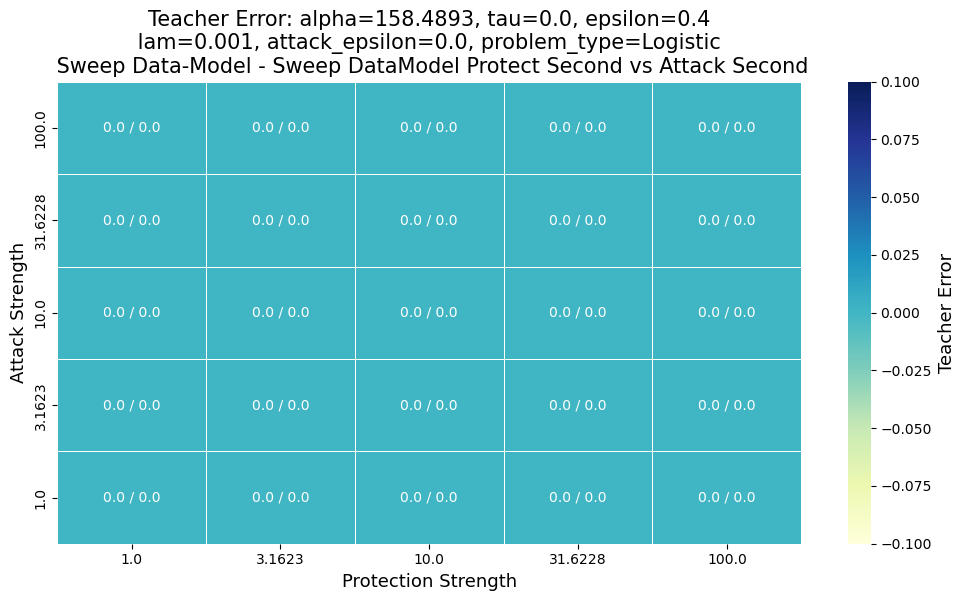

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


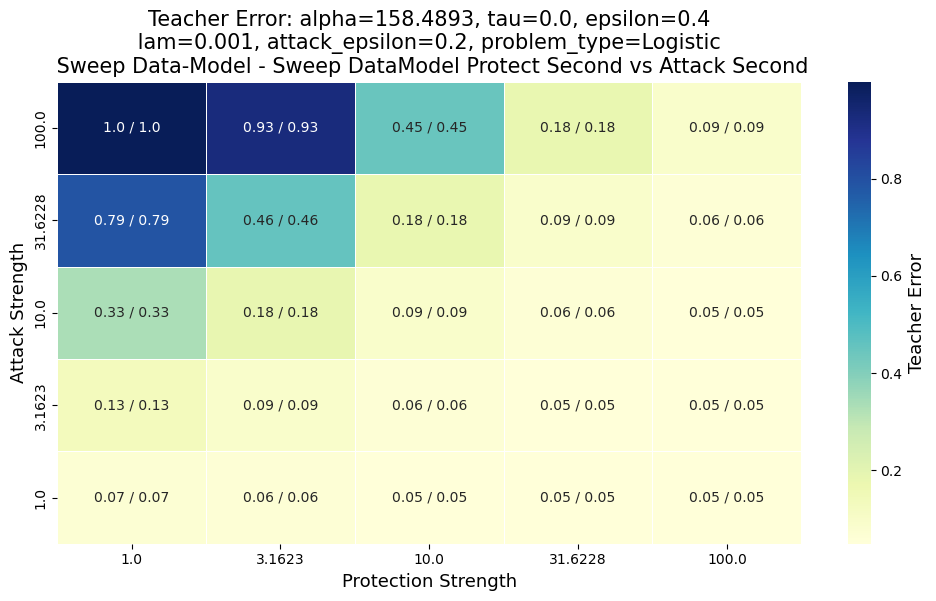

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


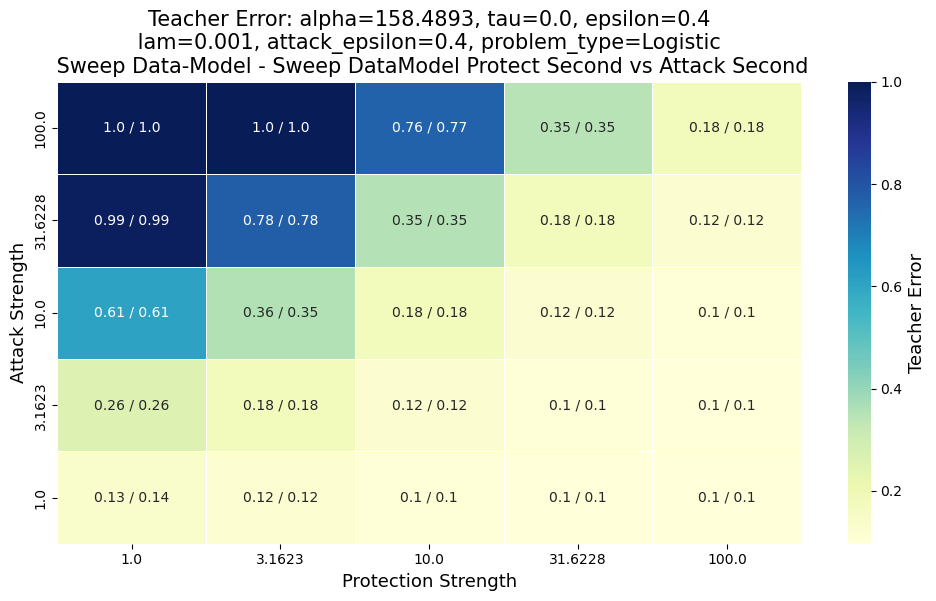

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


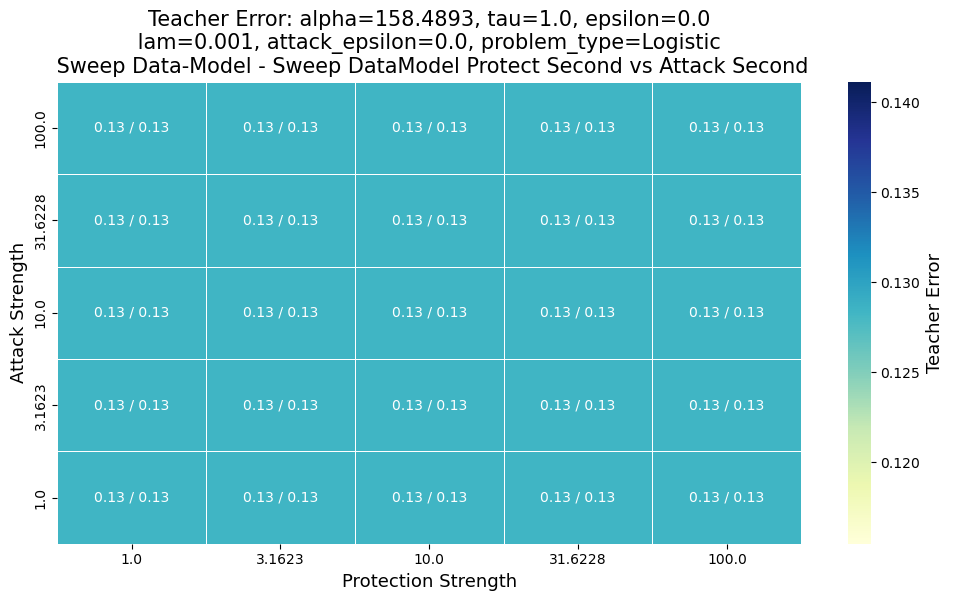

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


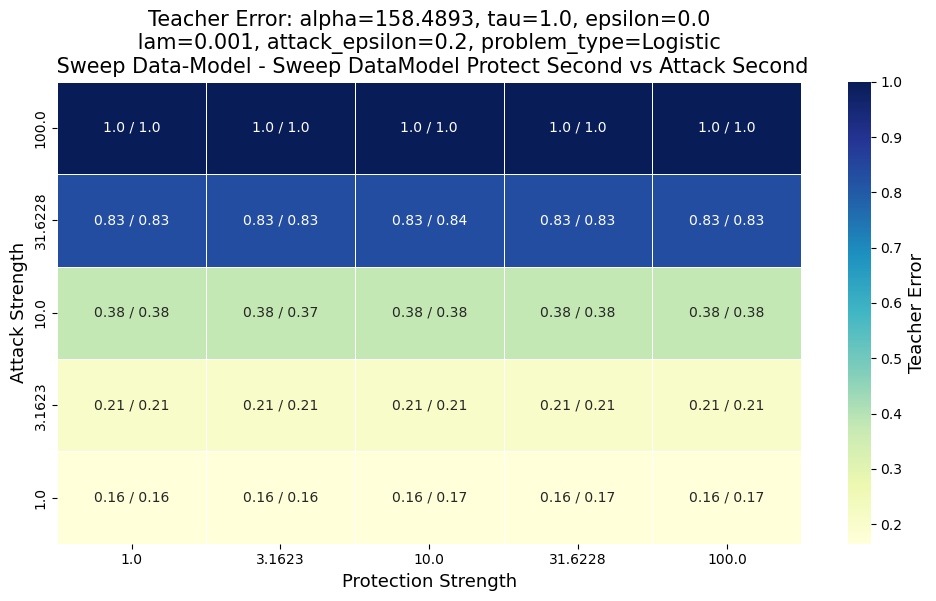

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


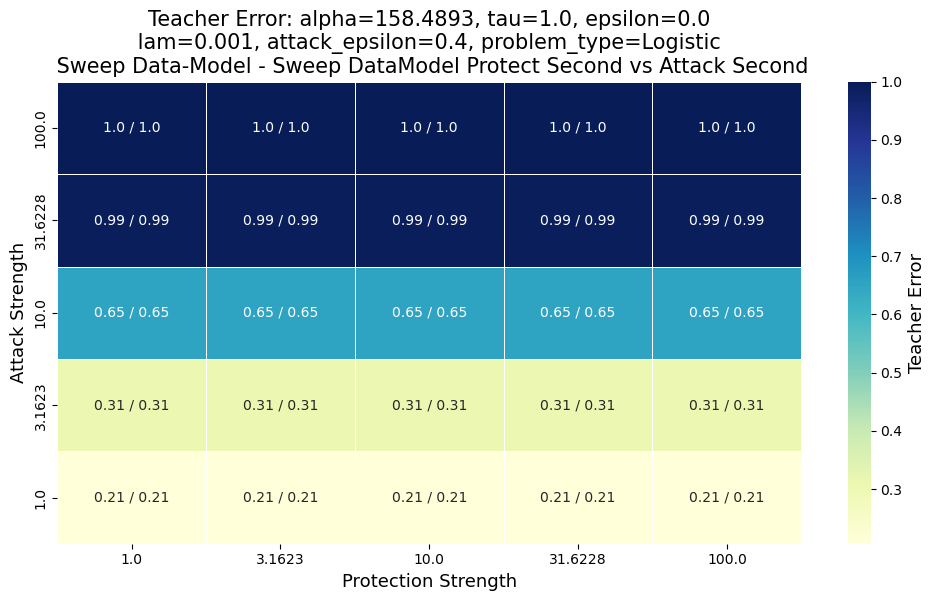

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


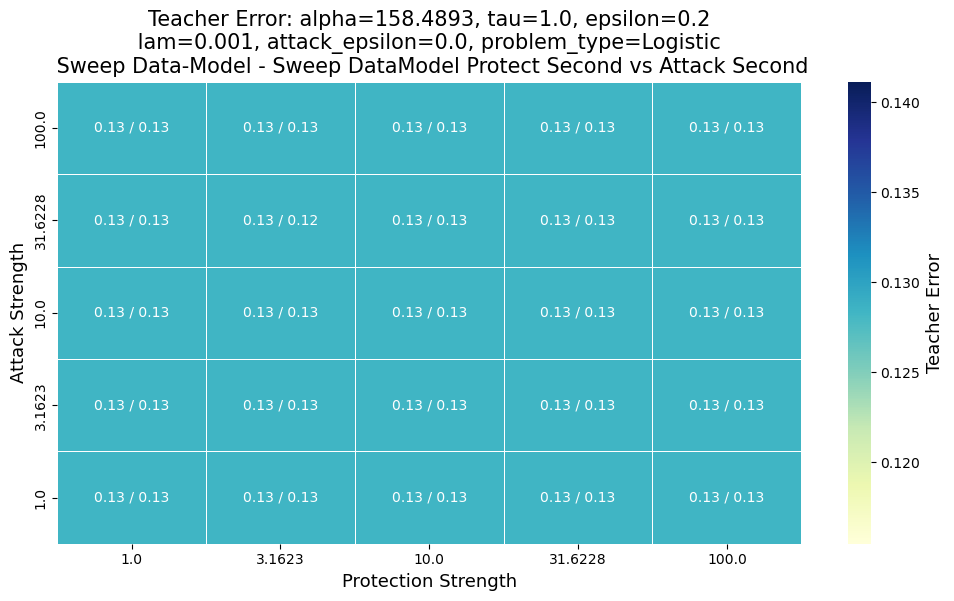

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


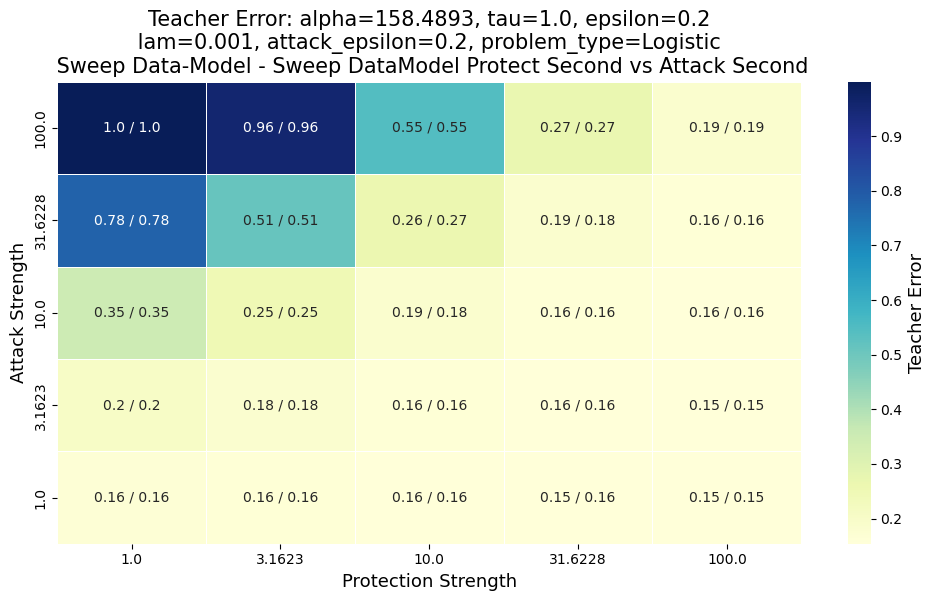

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


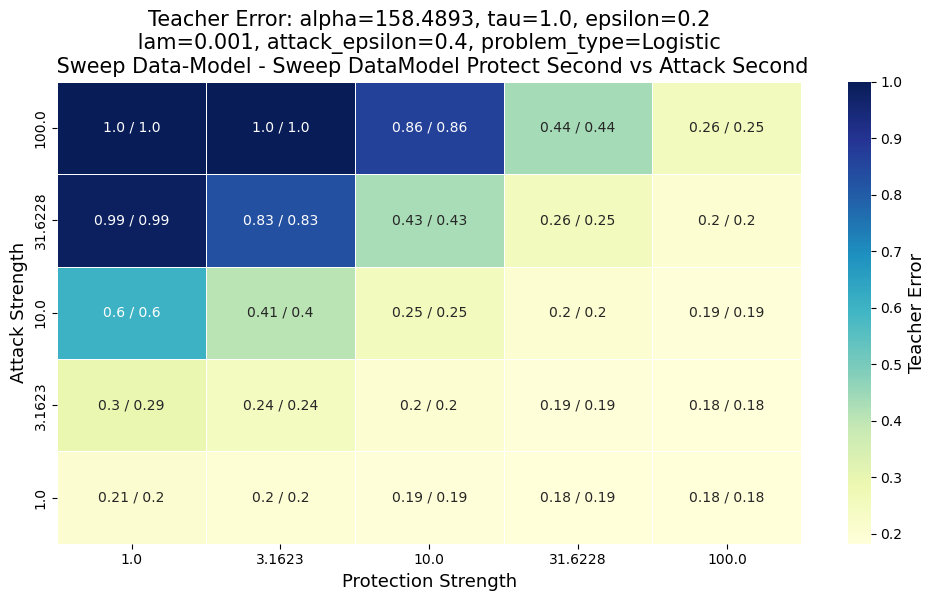

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


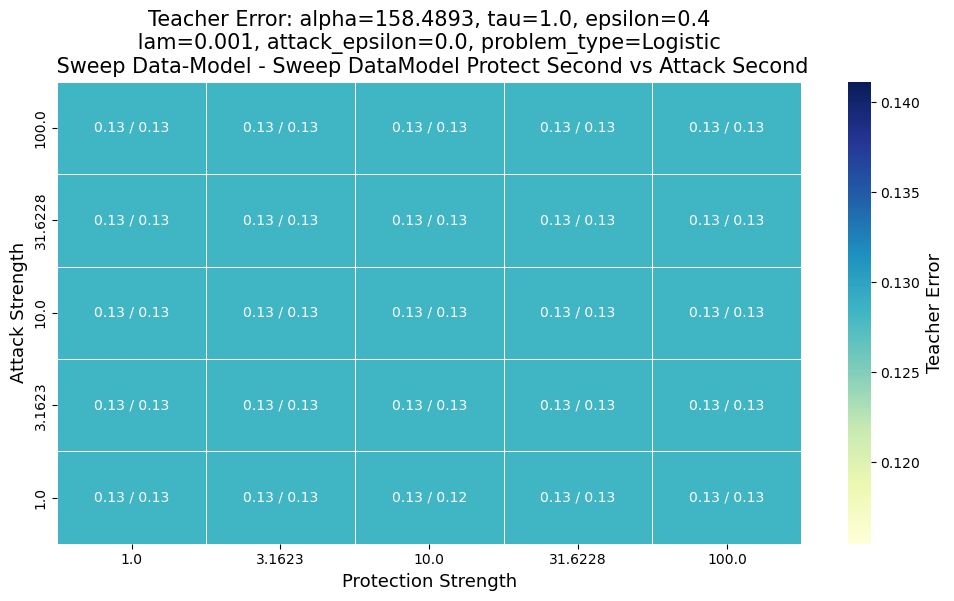

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


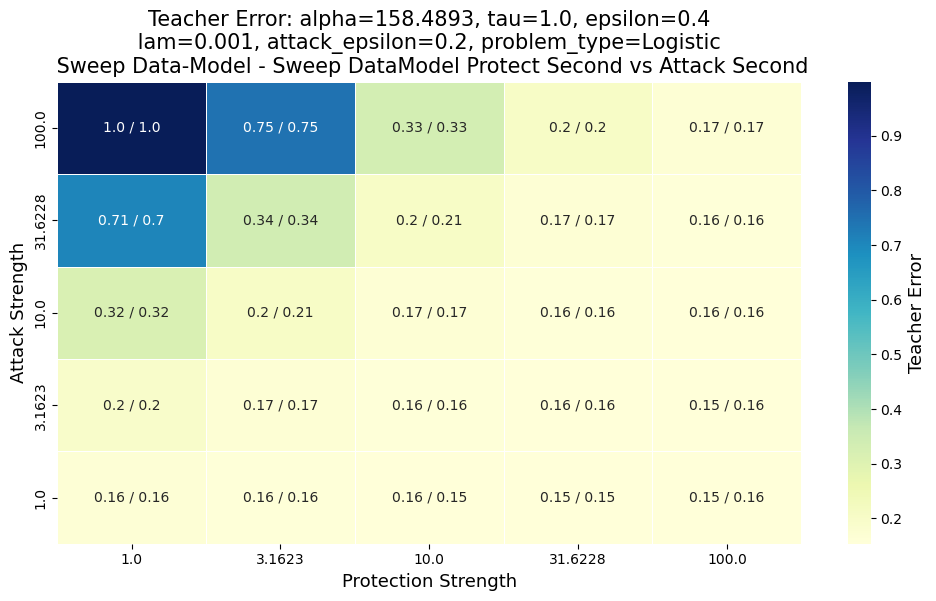

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


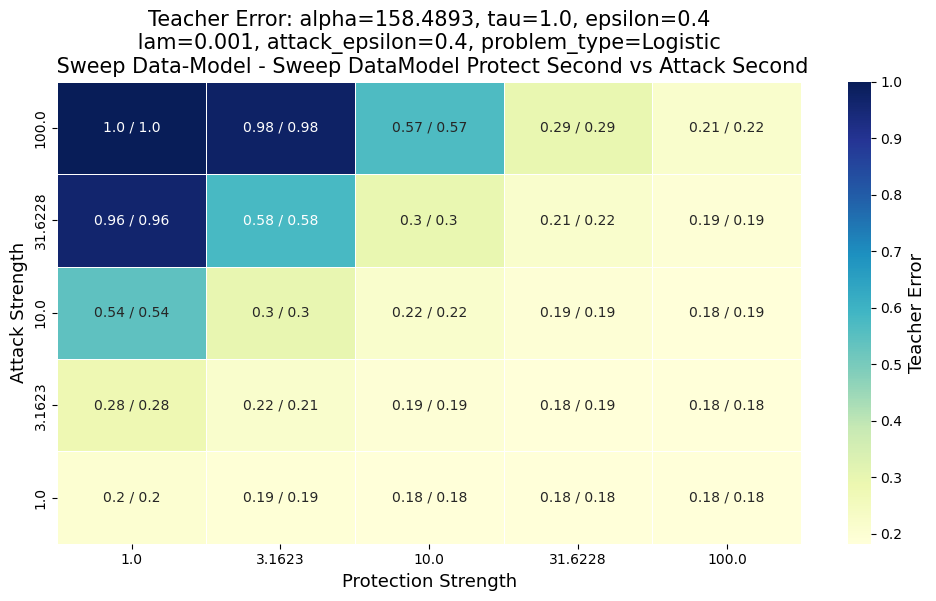

In [338]:
create_plot(df, "Teacher Error", "adversarial_generalization_error_teacher", iterate_attack_strengths=True, use_mean = True)

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


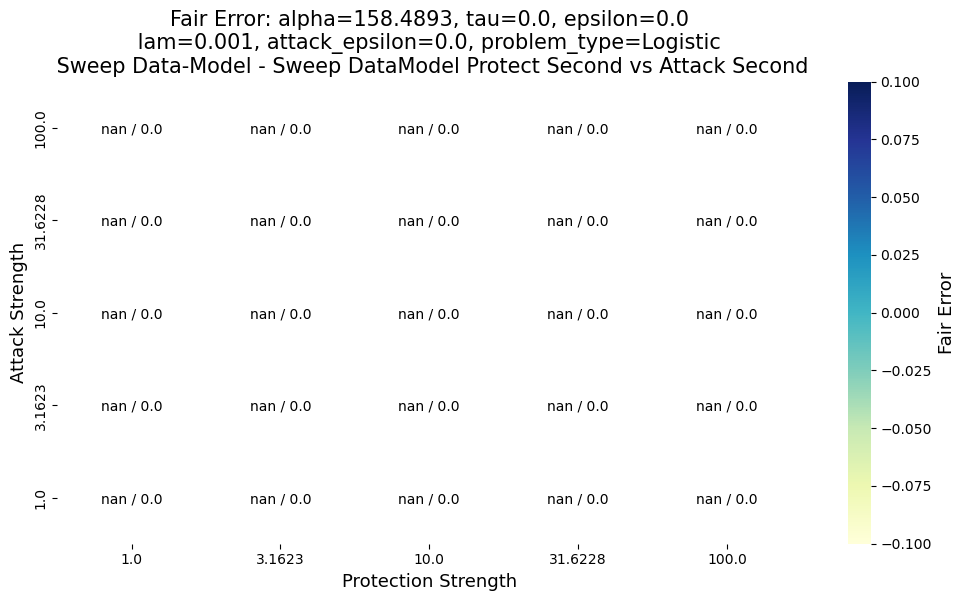

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


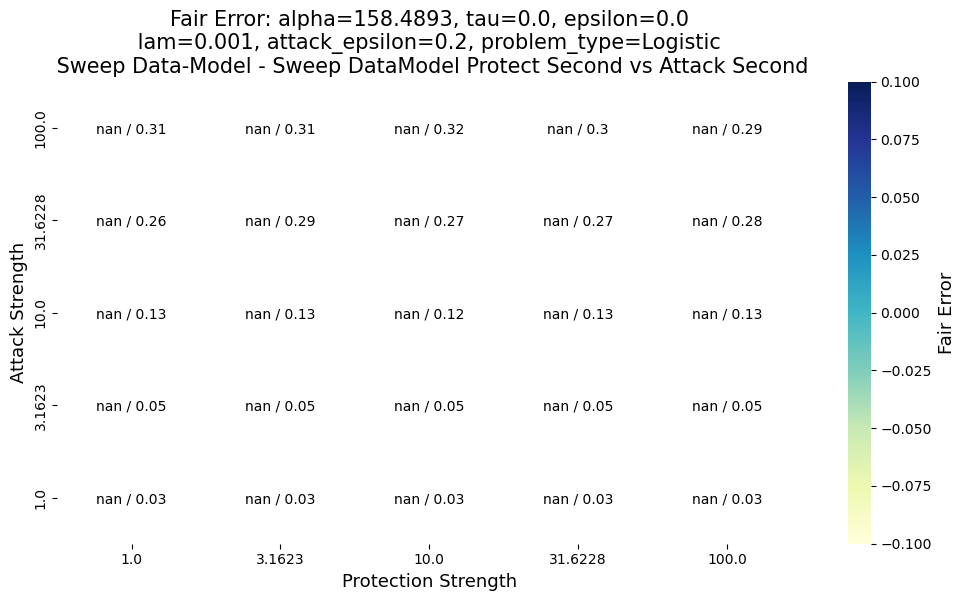

alpha:  158.4893  tau:  0.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


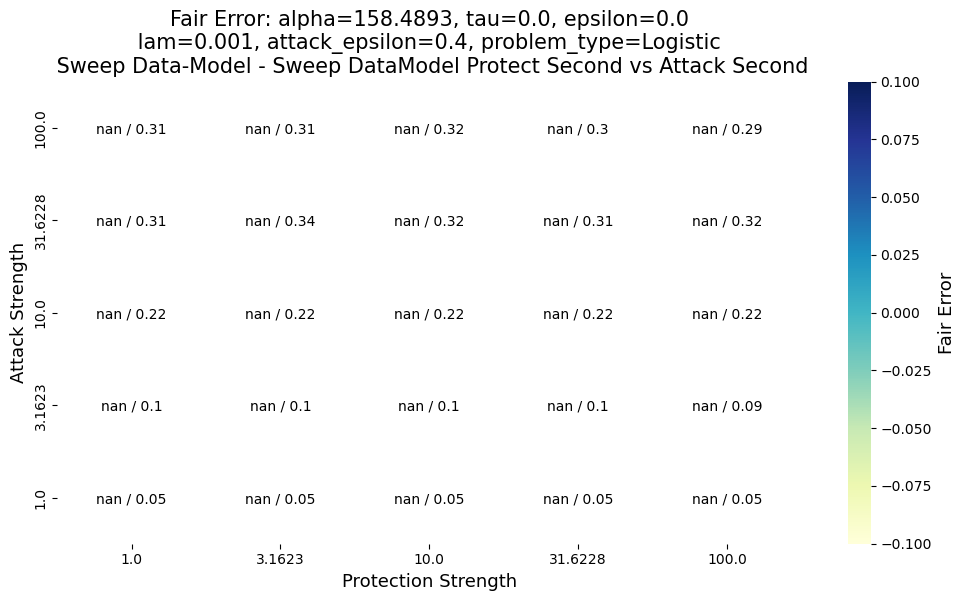

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


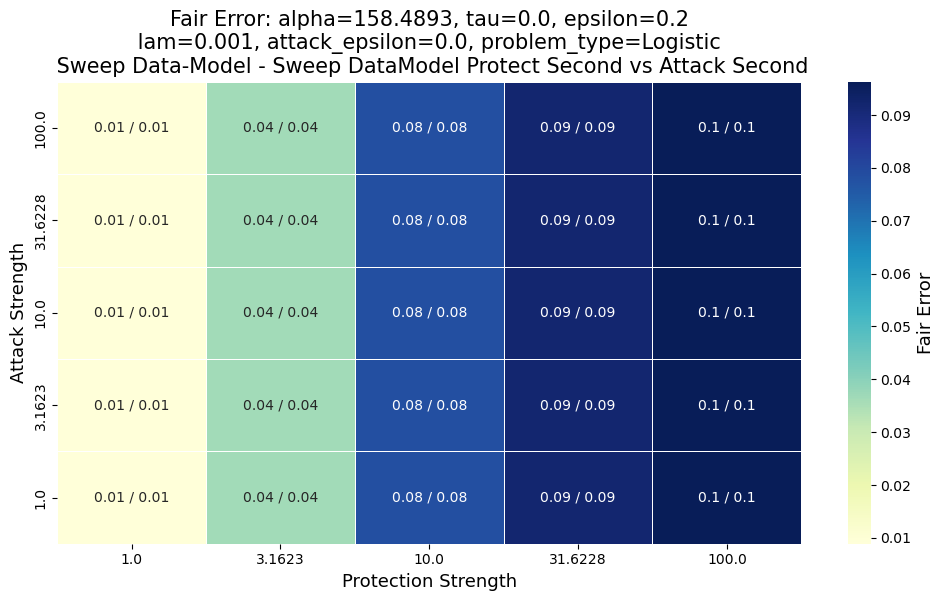

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


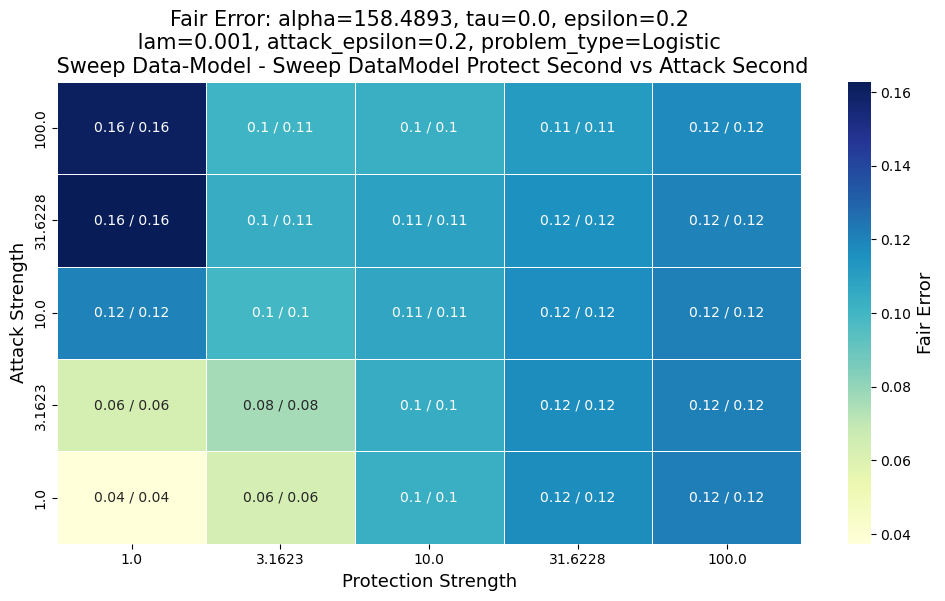

alpha:  158.4893  tau:  0.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


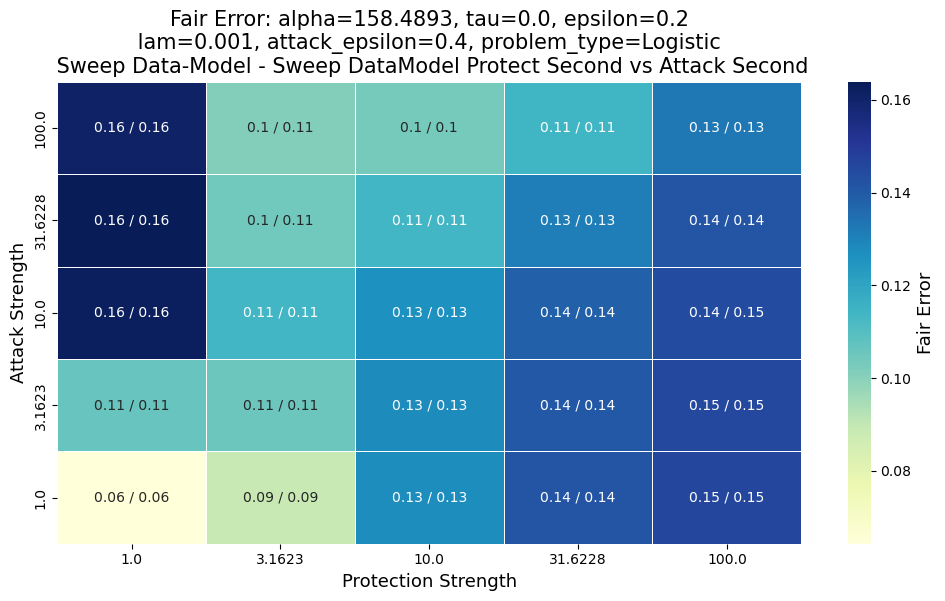

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


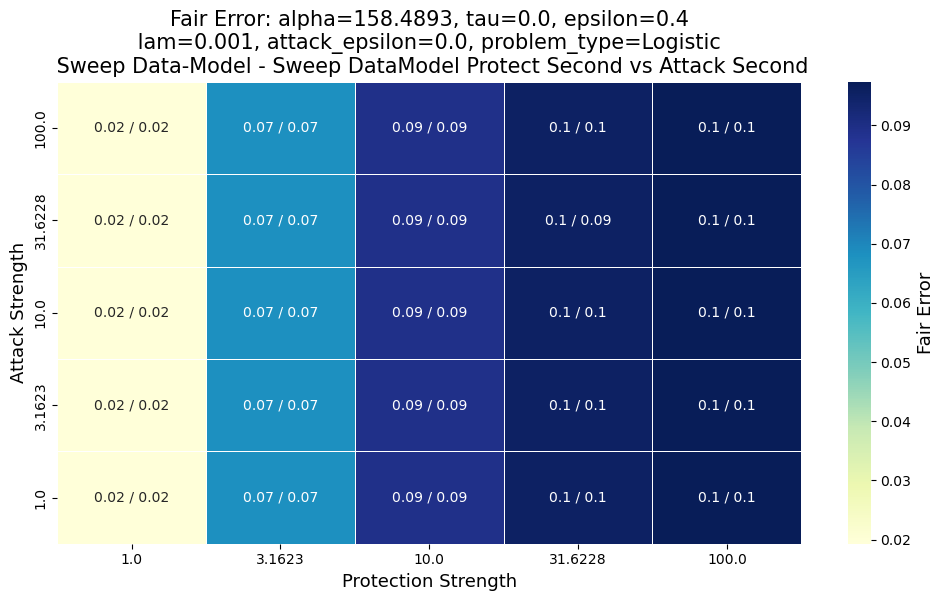

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


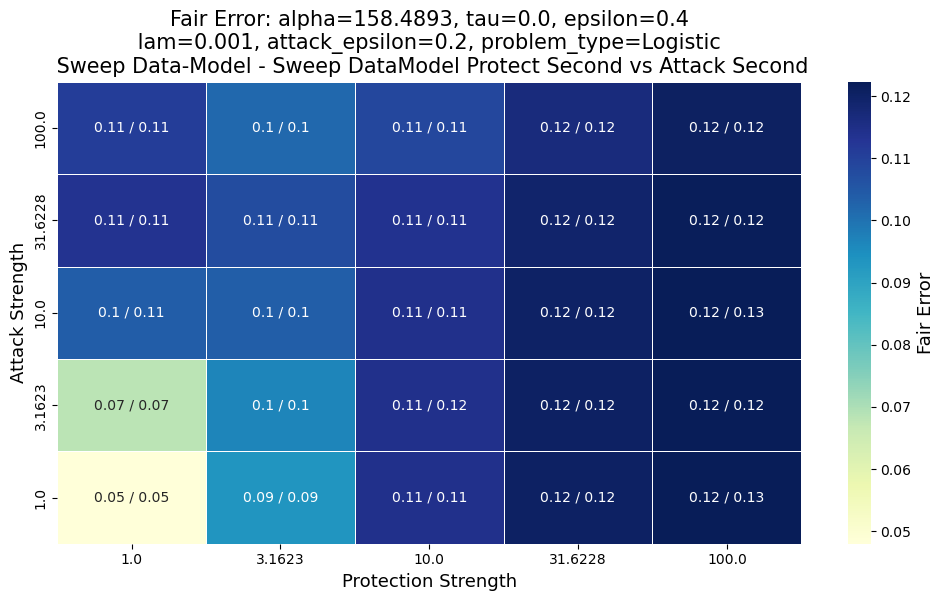

alpha:  158.4893  tau:  0.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


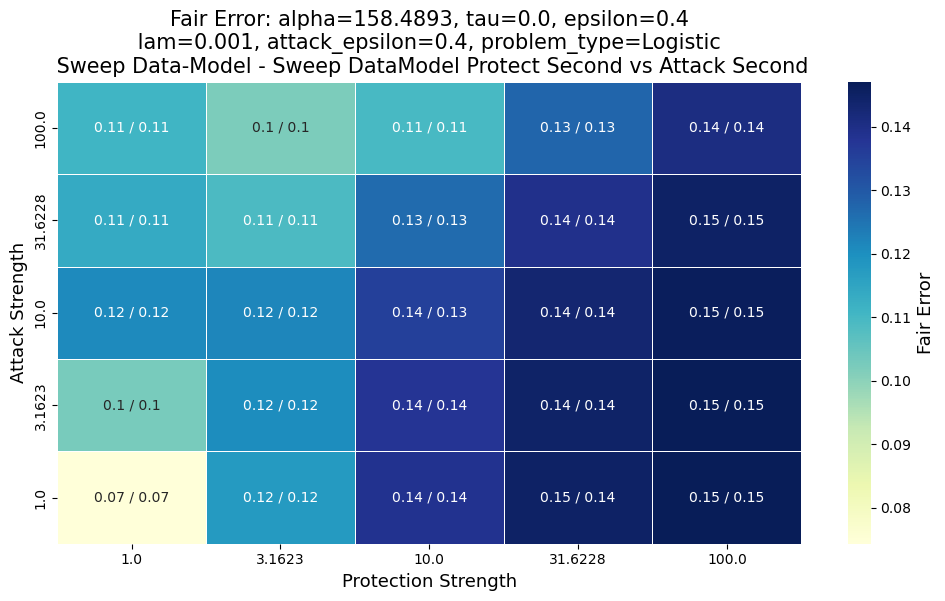

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


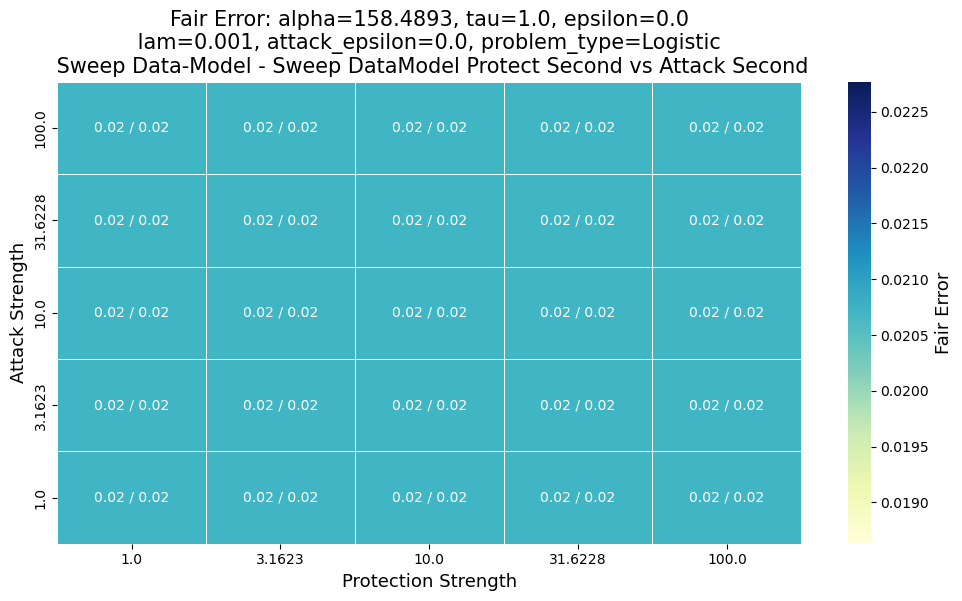

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


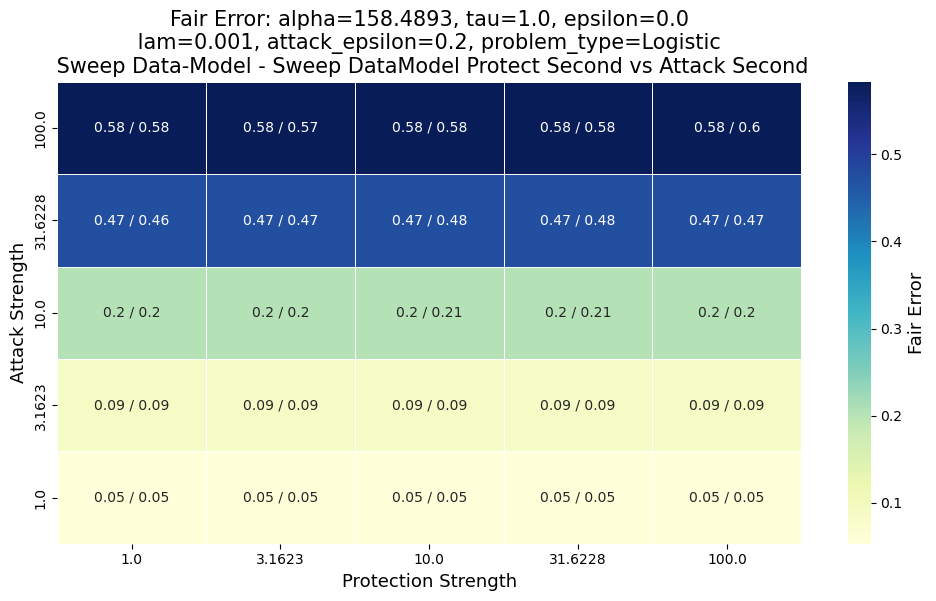

alpha:  158.4893  tau:  1.0  epsilon:  0.0  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


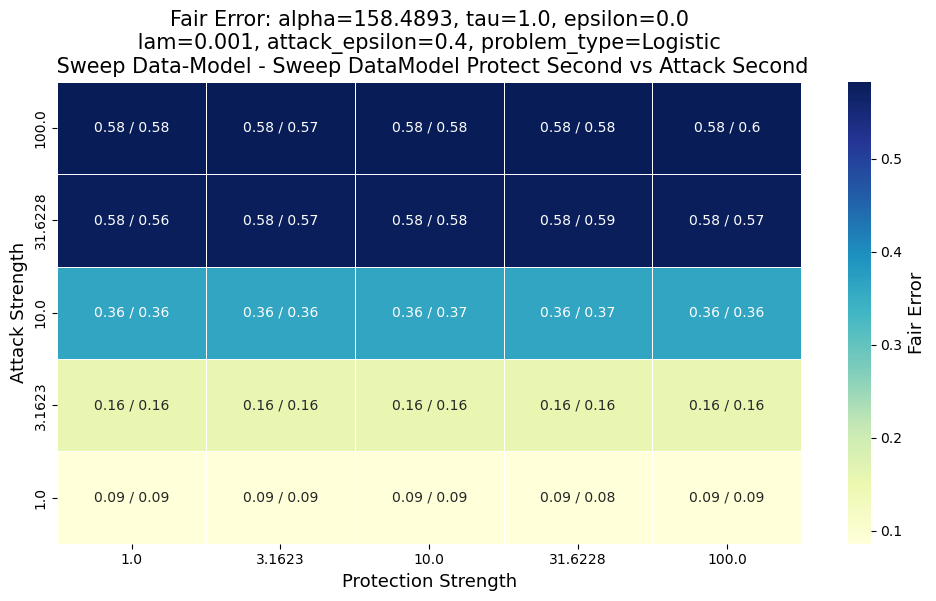

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


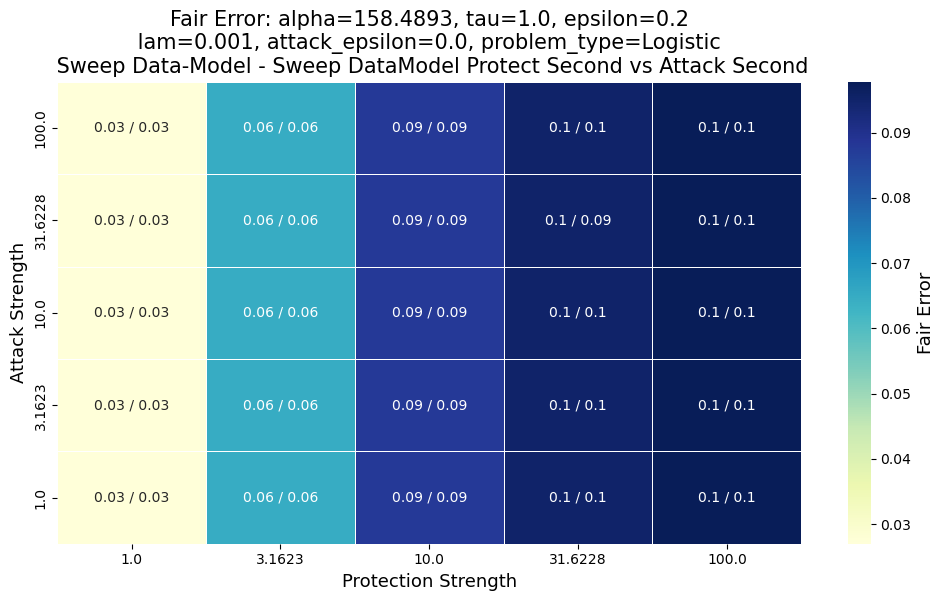

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


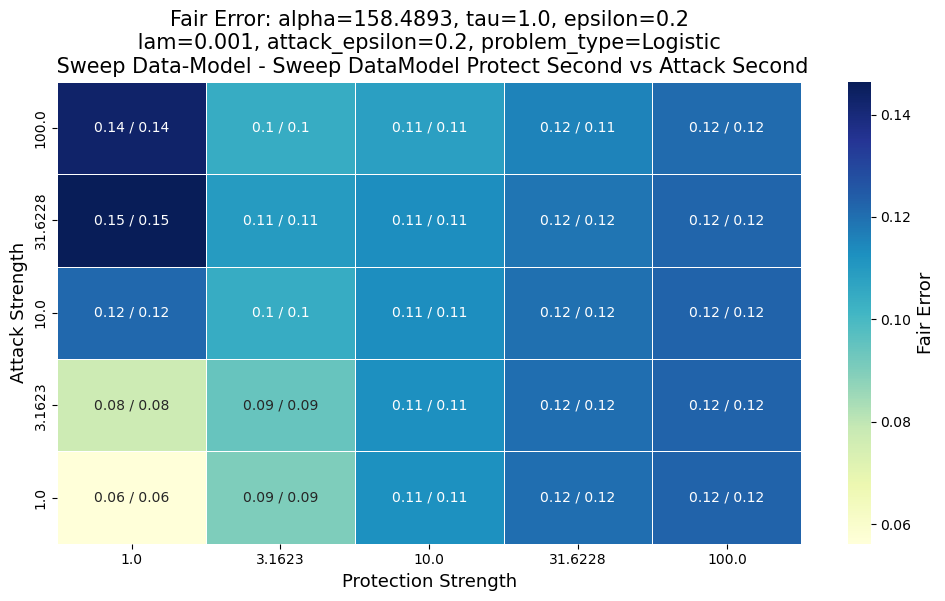

alpha:  158.4893  tau:  1.0  epsilon:  0.2  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


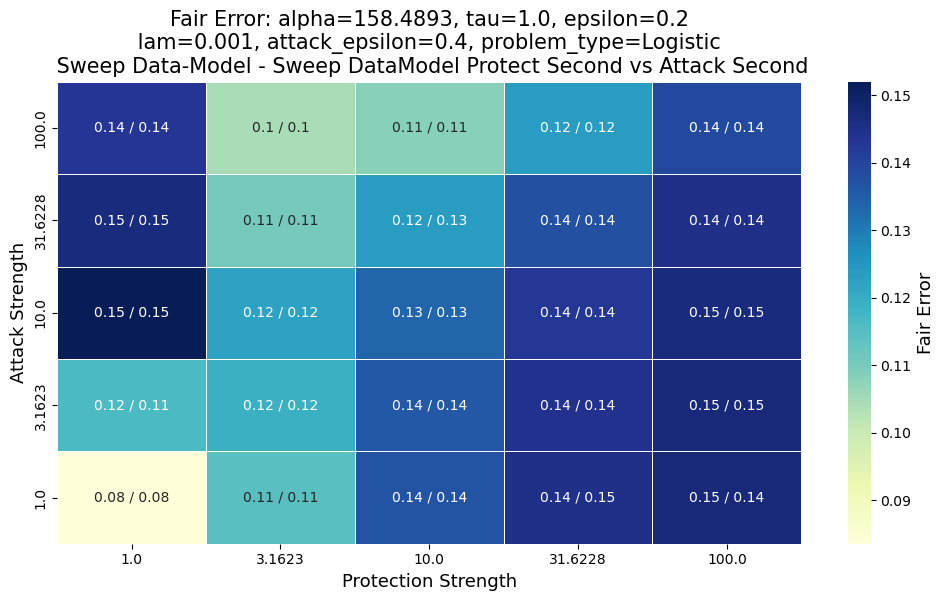

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.0  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


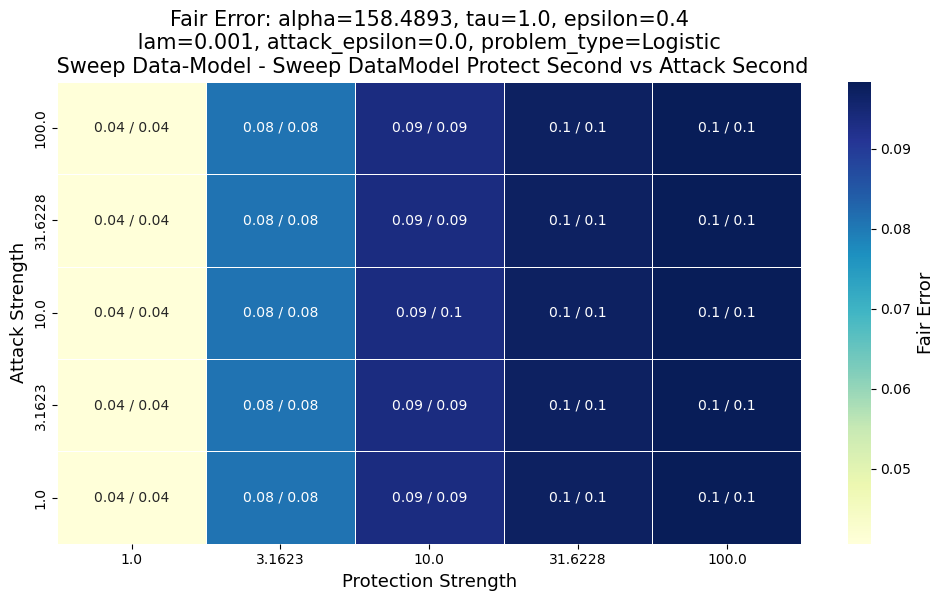

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.2  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


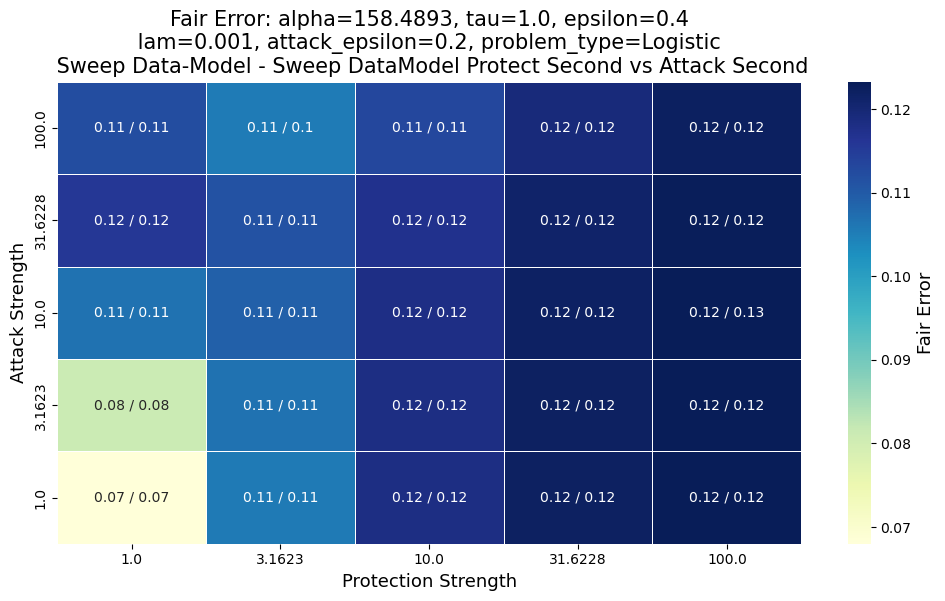

alpha:  158.4893  tau:  1.0  epsilon:  0.4  lam:  0.001  attack_epsilon:  0.4  problem_type:  Logistic


/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ktanner/venvs/adv/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


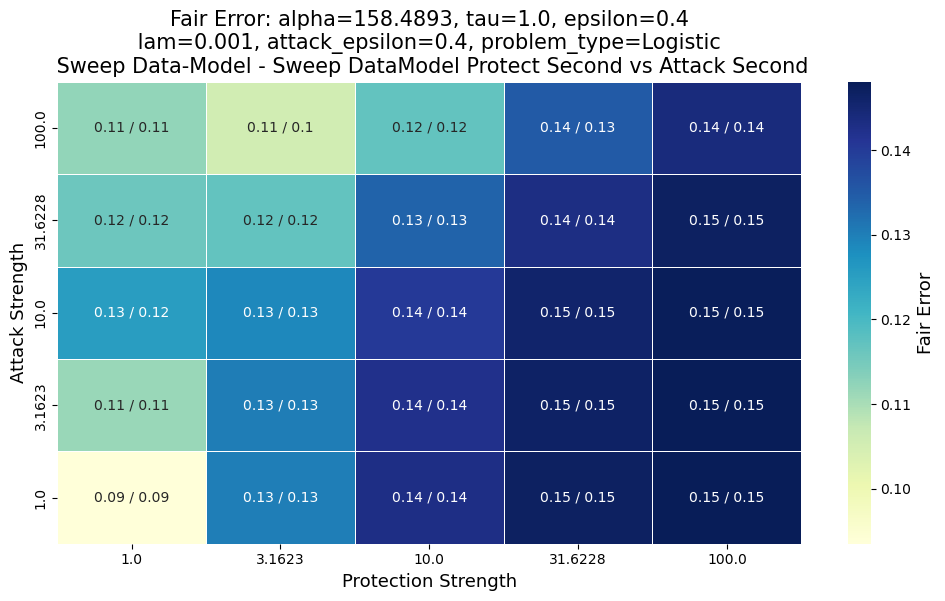

In [339]:
create_plot(df, "Fair Error", "fair_adversarial_error", iterate_attack_strengths=True, use_mean = True)